# Stage 1 (Merge DataSet & Missing Value)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno

In [2]:

# Load datasets
meteo_variables_df = pd.read_csv('meteo_variables.csv')
meteo_station_df = pd.read_csv('meteo_station.csv')
corn_yield_df = pd.read_csv('corn_yield.csv')

# Step 1: Process the Corn Yield Data
# Replace 'Variety' column with 'FAO cicle' and drop unnecessary columns.
# Convert percentages and calculate ear yields
corn_yield_df['Fresh Ear Percentage'] = pd.to_numeric(corn_yield_df['Fresh Ear Percentage'].str.replace(',', '.'), errors='coerce')
corn_yield_df['Fresh Total'] = pd.to_numeric(corn_yield_df['Fresh Total'].str.replace(',', '.'), errors='coerce')
corn_yield_df['Dry Ear Percentage'] = pd.to_numeric(corn_yield_df['Dry Ear Percentage'].str.replace(',', '.'), errors='coerce')
corn_yield_df['Dry Total'] = pd.to_numeric(corn_yield_df['Dry Total'].str.replace(',', '.'), errors='coerce')

corn_yield_df['Fresh Ear Yield'] = (corn_yield_df['Fresh Ear Percentage'] / 100) * corn_yield_df['Fresh Total']
corn_yield_df['Dry Ear Yield'] = (corn_yield_df['Dry Ear Percentage'] / 100) * corn_yield_df['Dry Total']

# Replace 'Variety' with 'FAO cicle'
corn_yield_df = corn_yield_df.drop(columns=['Variety', 'REP']).rename(columns={'FAO cicle': 'FAO Cycle'})

# Convert YEAR column to integer
corn_yield_df['YEAR'] = corn_yield_df['YEAR'].round().astype(int)

# Extract necessary columns
corn_yield_df = corn_yield_df[['YEAR', 'FAO Cycle', 'Fresh Ear Yield', 'Dry Ear Yield']]

# Display processed corn yield data
print("Processed Corn Yield Data:")
print(corn_yield_df.head())

# Step 2: Process the Meteo Station Data
# Rename columns for easier use based on meteo_variables description
meteo_station_df.rename(columns={
    'mt': 'mean_temp',
    'max t': 'max_temp',
    'min t': 'min_temp',
    'rh': 'mean_humidity',
    'pl': 'precipitation',
    'srad': 'solar_radiation',
    'evap': 'evapotranspiration',
    'ws': 'mean_wind_speed',
    'wsmag': 'max_wind_speed'
}, inplace=True)

# Convert the 'date' column to datetime
meteo_station_df['date'] = pd.to_datetime(meteo_station_df['date'], format='%d/%m/%Y')

# Expanded list of variables to calculate for each month (March to October)
n_variables = [
    'mean_temp',
    'max_temp',
    'min_temp',
    'precipitation',
    'dry_days',  
    'wet_days',  
    'precipitation_intensity', 
    'solar_radiation',
    'solar_variability',  
    'mean_humidity',
    'humidity_range',  
    'low_humidity_days',  
    'mean_wind_speed',
    'wind_range',  
    'high_wind_days',  
    'evapotranspiration'
]

# Create a DataFrame to hold the expanded features
expanded_features = []

for index, row in corn_yield_df.iterrows():
    year = row['YEAR']
    relevant_data = meteo_station_df[meteo_station_df['date'].dt.year == year]

    # Filter for months March to October
    relevant_data = relevant_data[(relevant_data['date'].dt.month >= 3) & (relevant_data['date'].dt.month <= 10)]

    monthly_data = relevant_data.groupby(relevant_data['date'].dt.month)

    features = {'YEAR': int(row['YEAR']), 'FAO Cycle': row['FAO Cycle'], 
                'Fresh Ear Yield': row['Fresh Ear Yield'], 'Dry Ear Yield': row['Dry Ear Yield']}

    for month in range(3, 11):  # March (3) to October (10)
        month_name = pd.to_datetime(f'2022-{month:02d}-01').strftime('%B')
        if month in monthly_data.groups:
            month_data = monthly_data.get_group(month)

            features.update({
                f'mean_temp {month_name}': month_data['mean_temp'].mean(),
                f'max_temp {month_name}': month_data['max_temp'].max(),
                f'min_temp {month_name}': month_data['min_temp'].min(),
                f'precipitation {month_name}': month_data['precipitation'].sum(),
                f'dry_days {month_name}': (month_data['precipitation'] == 0).sum(),
                f'wet_days {month_name}': (month_data['precipitation'] > 10).sum(),
                f'precipitation_intensity {month_name}': month_data['precipitation'].sum() / max(1, (month_data['precipitation'] > 10).sum()),
                f'solar_radiation {month_name}': month_data['solar_radiation'].sum(),
                f'solar_variability {month_name}': month_data['solar_radiation'].std(),
                f'mean_humidity {month_name}': month_data['mean_humidity'].mean(),
                f'humidity_range {month_name}': month_data['mean_humidity'].max() - month_data['mean_humidity'].min(),
                f'low_humidity_days {month_name}': (month_data['mean_humidity'] < 30).sum(),
                f'mean_wind_speed {month_name}': month_data['mean_wind_speed'].mean(),
                f'wind_range {month_name}': month_data['mean_wind_speed'].max() - month_data['mean_wind_speed'].min(),
                f'high_wind_days {month_name}': (month_data['mean_wind_speed'] > 10).sum(),
                f'evapotranspiration {month_name}': month_data['evapotranspiration'].sum()
            })
        else:
            for variable in n_variables:
                features[f'{variable} {month_name}'] = np.nan

    expanded_features.append(features)

expanded_features_df = pd.DataFrame(expanded_features)


for column in expanded_features_df.columns[4:]: 
    median_value = expanded_features_df[column].median(skipna=True)
    expanded_features_df[column].fillna(median_value, inplace=True)

# Check that the correct number of columns is present
expected_columns = 4 + len(n_variables) * 8  # 4 static columns + (variables * 8 months)

# Print debugging information for columns
print("Generated columns:", expanded_features_df.columns.tolist())
print(f"Expected columns: {expected_columns}, Actual columns: {len(expanded_features_df.columns)}")
assert len(expanded_features_df.columns) == expected_columns, f"Unexpected number of columns: {len(expanded_features_df.columns)}"

# Save the expanded features DataFrame to a CSV file
output_path = 'Monthly_Data_Set_March_to_October.csv'
expanded_features_df.to_csv(output_path, index=False)



Processed Corn Yield Data:
   YEAR  FAO Cycle  Fresh Ear Yield  Dry Ear Yield
0  2012        260        20.761600      11.002332
1  2012        200        22.886100      13.272189
2  2012        200        17.326176       8.539348
3  2012        260        23.331706      13.945230
4  2012        200        17.629940       9.830720
Generated columns: ['YEAR', 'FAO Cycle', 'Fresh Ear Yield', 'Dry Ear Yield', 'mean_temp March', 'max_temp March', 'min_temp March', 'precipitation March', 'dry_days March', 'wet_days March', 'precipitation_intensity March', 'solar_radiation March', 'solar_variability March', 'mean_humidity March', 'humidity_range March', 'low_humidity_days March', 'mean_wind_speed March', 'wind_range March', 'high_wind_days March', 'evapotranspiration March', 'mean_temp April', 'max_temp April', 'min_temp April', 'precipitation April', 'dry_days April', 'wet_days April', 'precipitation_intensity April', 'solar_radiation April', 'solar_variability April', 'mean_humidity April'

/var/folders/5y/vmqy4y397_d5hs8nmp4c5c8r0000gn/T/ipykernel_1564/1765785122.py:116: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  expanded_features_df[column].fillna(median_value, inplace=True)


In [3]:
df = pd.read_csv('Monthly_Data_Set_March_to_October.csv')
df

,YEAR,FAO Cycle,Fresh Ear Yield,Dry Ear Yield,mean_temp March,max_temp March,min_temp March,precipitation March,dry_days March,wet_days March,...,precipitation_intensity October,solar_radiation October,solar_variability October,mean_humidity October,humidity_range October,low_humidity_days October,mean_wind_speed October,wind_range October,high_wind_days October,evapotranspiration October
0,2012,260.0,20.761600,11.002332,9.725806,24.4,-0.3,41.2,12.0,0.0,...,24.133333,274.0,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44
1,2012,200.0,22.886100,13.272189,9.725806,24.4,-0.3,41.2,12.0,0.0,...,24.133333,274.0,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44
2,2012,200.0,17.326176,8.539348,9.725806,24.4,-0.3,41.2,12.0,0.0,...,24.133333,274.0,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44
3,2012,260.0,23.331706,13.945230,9.725806,24.4,-0.3,41.2,12.0,0.0,...,24.133333,274.0,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44
4,2012,200.0,17.629940,9.830720,9.725806,24.4,-0.3,41.2,12.0,0.0,...,24.133333,274.0,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,2023,430.0,19.743750,11.208912,12.087097,28.6,-0.4,23.4,15.0,0.0,...,53.500000,241.5,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90
848,2023,600.0,26.036140,15.351504,12.087097,28.6,-0.4,23.4,15.0,0.0,...,53.500000,241.5,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90
849,2023,400.0,27.934410,17.977534,12.087097,28.6,-0.4,23.4,15.0,0.0,...,53.500000,241.5,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90
850,2023,400.0,21.541464,13.907824,12.087097,28.6,-0.4,23.4,15.0,0.0,...,53.500000,241.5,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90


In [4]:
df.dtypes

YEAR                            int64
FAO Cycle                     float64
Fresh Ear Yield               float64
Dry Ear Yield                 float64
mean_temp March               float64
                               ...   
low_humidity_days October     float64
mean_wind_speed October       float64
wind_range October            float64
high_wind_days October        float64
evapotranspiration October    float64
Length: 132, dtype: object

In [5]:
df.isna().sum()

YEAR                           0
FAO Cycle                      0
Fresh Ear Yield               21
Dry Ear Yield                 21
mean_temp March                0
                              ..
low_humidity_days October      0
mean_wind_speed October        0
wind_range October             0
high_wind_days October         0
evapotranspiration October     0
Length: 132, dtype: int64

<Axes: >

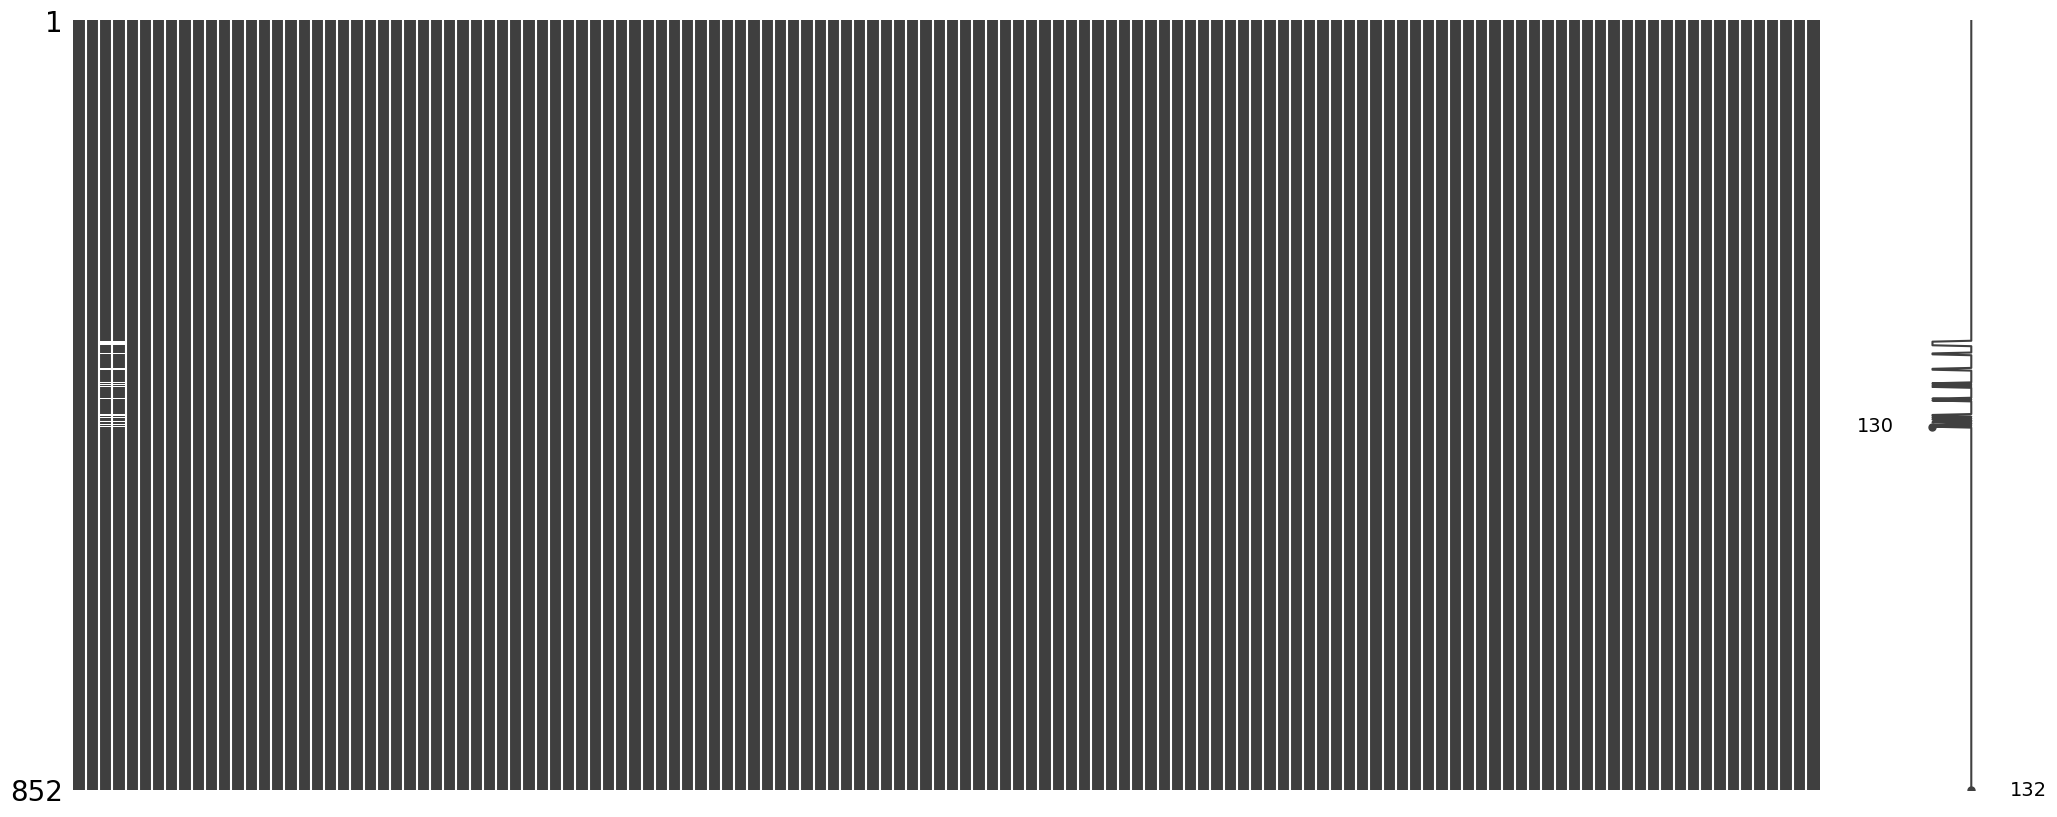

In [6]:
msno.matrix(df)

In [7]:
df.isna().sum()

YEAR                           0
FAO Cycle                      0
Fresh Ear Yield               21
Dry Ear Yield                 21
mean_temp March                0
                              ..
low_humidity_days October      0
mean_wind_speed October        0
wind_range October             0
high_wind_days October         0
evapotranspiration October     0
Length: 132, dtype: int64

In [8]:
# Remove all missing values (NaN) in the follow column 
columns = ['Fresh Ear Yield', 'Dry Ear Yield']

# Drop rows with missing values in the specified columns
df = df.dropna(subset=columns)

# Display the updated dataset
print(f"Data after removing missing values: {df.shape}")


Data after removing missing values: (831, 132)


<Axes: >

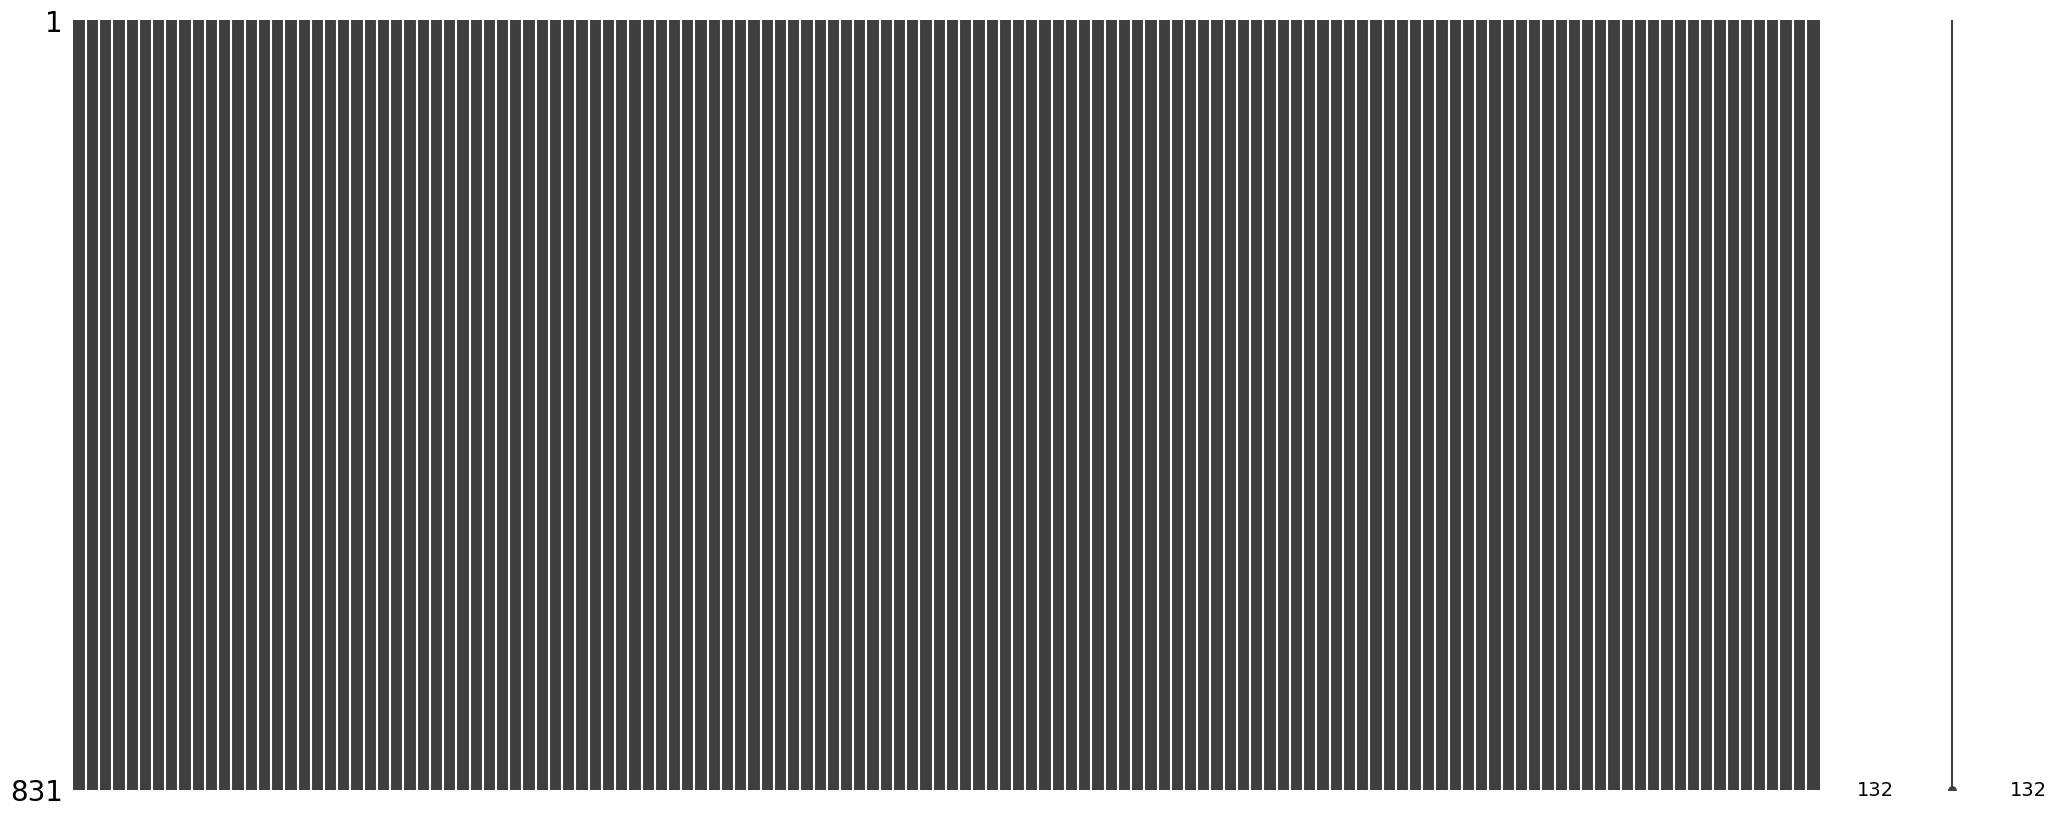

In [9]:
msno.matrix(df)

In [10]:
# Define the target columns
target_columns = ['Fresh Ear Yield','Dry Ear Yield']

# Reorder the DataFrame to move the target columns to the end
columns_reordered = [col for col in df.columns if col not in target_columns] + target_columns
df = df[columns_reordered]

# Display the first few rows of the reordered DataFrame
df.head()

,YEAR,FAO Cycle,mean_temp March,max_temp March,min_temp March,precipitation March,dry_days March,wet_days March,precipitation_intensity March,solar_radiation March,...,solar_variability October,mean_humidity October,humidity_range October,low_humidity_days October,mean_wind_speed October,wind_range October,high_wind_days October,evapotranspiration October,Fresh Ear Yield,Dry Ear Yield
0,2012,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,20.761600,11.002332
1,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,22.886100,13.272189
2,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.326176,8.539348
3,2012,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,23.331706,13.945230
4,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.629940,9.830720


In [11]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df

,year,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
0,2012,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44,20.761600,11.002332
1,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44,22.886100,13.272189
2,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44,17.326176,8.539348
3,2012,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44,23.331706,13.945230
4,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.2,412.7,...,4.076492,81.061290,18.7,0.0,0.332258,0.9,0.0,29.44,17.629940,9.830720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,2023,430.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,19.743750,11.208912
848,2023,600.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,26.036140,15.351504
849,2023,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,27.934410,17.977534
850,2023,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,21.541464,13.907824


# Stage 2 (Train-Test Split)

In [12]:
# Define the training and test sets based on years
train_df = df[df['year'].between(2012, 2020)]
test_df = df[df['year'].between(2021, 2023)]

# Display the sizes of the splits
print(f"Training set size: {train_df.shape}")
print(f"Test set size: {test_df.shape}")

# Save the splits to CSV for further processing if needed
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)


Training set size: (627, 132)
Test set size: (204, 132)


In [13]:
train_df

,year,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
0,2012,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,20.761600,11.002332
1,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,22.886100,13.272189
2,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.326176,8.539348
3,2012,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,23.331706,13.945230
4,2012,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.629940,9.830720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,2020,360.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,14.608960,7.610601
644,2020,500.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,22.177317,12.265770
645,2020,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.408140,11.247489
646,2020,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.780860,10.540848


# Stage 3 (EDA & Feature Engineering)

In [14]:
# Exploratory Data Analysis (EDA) on the train_df dataset to gain insights into its structure, 
print("Train Set Info:")
print(train_df.info())

# Descriptive statistics
print("Descriptive Statistics:")
print(train_df.describe())

# Check for missing values
print("Missing Values in Train Set:")
print(train_df.isnull().sum())

Train Set Info:
<class 'pandas.core.frame.DataFrame'>
Index: 627 entries, 0 to 647
Columns: 132 entries, year to dry_ear_yield
dtypes: float64(131), int64(1)
memory usage: 651.5 KB
None
Descriptive Statistics:
              year   fao_cycle  mean_temp_march  max_temp_march  \
count   627.000000  627.000000       627.000000      627.000000   
mean   2015.931419  306.842105        10.363678       23.954545   
std       2.662019   74.894466         0.465860        1.199291   
min    2012.000000  180.000000         9.725806       22.200000   
25%    2014.000000  260.000000         9.870968       23.600000   
50%    2016.000000  300.000000        10.470968       23.900000   
75%    2018.000000  350.000000        10.470968       24.400000   
max    2020.000000  600.000000        11.012903       26.100000   

       min_temp_march  precipitation_march  dry_days_march  wet_days_march  \
count      627.000000           627.000000      627.000000      627.000000   
mean         0.307974         

Columns in train_df: Index(['year', 'fao_cycle', 'mean_temp_march', 'max_temp_march',
       'min_temp_march', 'precipitation_march', 'dry_days_march',
       'wet_days_march', 'precipitation_intensity_march',
       'solar_radiation_march',
       ...
       'solar_variability_october', 'mean_humidity_october',
       'humidity_range_october', 'low_humidity_days_october',
       'mean_wind_speed_october', 'wind_range_october',
       'high_wind_days_october', 'evapotranspiration_october',
       'fresh_ear_yield', 'dry_ear_yield'],
      dtype='object', length=132)


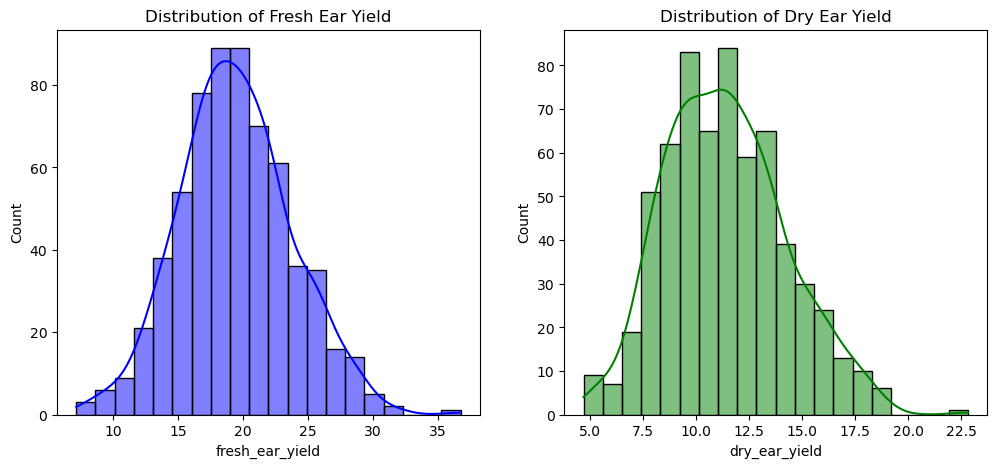

In [15]:
# Check the column names of train_df
print("Columns in train_df:", train_df.columns)

# follow code creates a side-by-side comparison of the distributions for the fresh_ear_yield and dry_ear_yield features 
# in the train_df dataset using histograms and Kernel Density Estimation (KDE).

plt.figure(figsize=(12, 5))

# Fresh Ear Yield
plt.subplot(1, 2, 1)
sns.histplot(train_df['fresh_ear_yield'], kde=True, bins=20, color='blue')
plt.title('Distribution of Fresh Ear Yield')

# Dry Ear Yield
plt.subplot(1, 2, 2)
sns.histplot(train_df['dry_ear_yield'], kde=True, bins=20, color='green')
plt.title('Distribution of Dry Ear Yield')

plt.show()


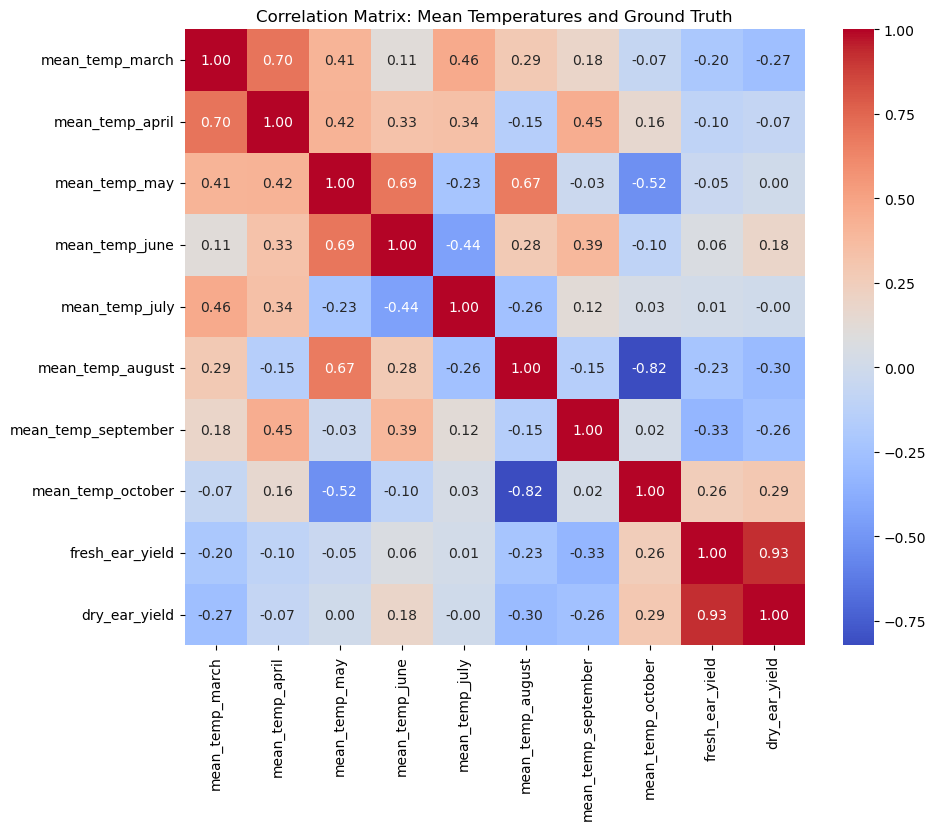

In [16]:
# Filter columns for mean temperature and ground truth
columns_to_analyze = [col for col in train_df.columns if 'mean_temp' in col] + ['fresh_ear_yield', 'dry_ear_yield']

# Calculate the correlation matrix
correlation_matrix = train_df[columns_to_analyze].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Mean Temperatures and Ground Truth")
plt.show()


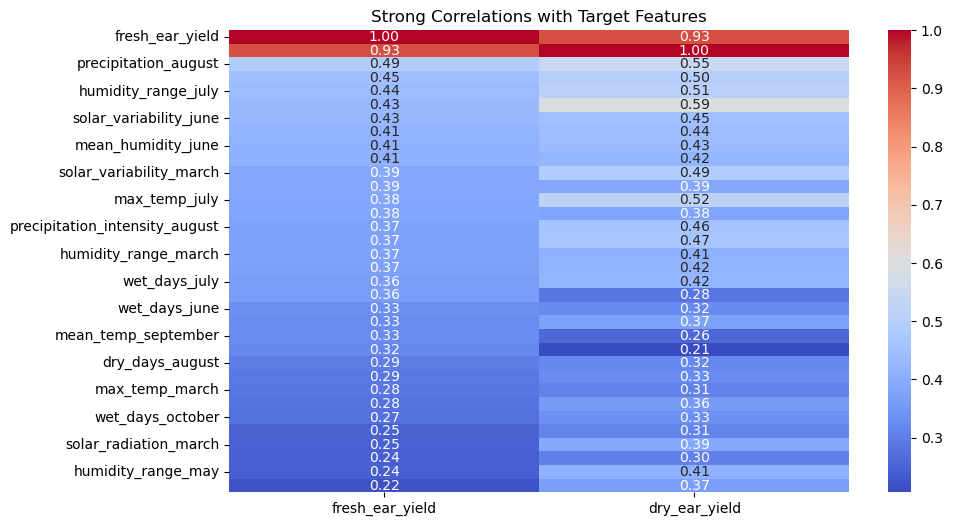

In [17]:
# This code performs a feature correlation analysis to identify and visualize features that are strongly correlated 
# with the target variables (fresh_ear_yield and dry_ear_yield).


# Calculate correlation matrix for numeric features
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()

# Extract correlation with target features
target_features = ['fresh_ear_yield', 'dry_ear_yield']
correlation_with_targets = correlation_matrix[target_features]

# Take absolute values of correlations and filter for strong correlations (>|0.30|)
strong_correlation = correlation_with_targets[
    (correlation_with_targets.abs() > 0.30).any(axis=1)
].abs().sort_values(by=target_features, ascending=False)

# Plot heatmap for strong correlations
plt.figure(figsize=(10, 6))
sns.heatmap(strong_correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Strong Correlations with Target Features")
plt.show()

In [18]:
# remove year column

train_df.drop(columns=['year'], inplace=True)
test_df.drop(columns=['year'], inplace=True)

/var/folders/5y/vmqy4y397_d5hs8nmp4c5c8r0000gn/T/ipykernel_1564/2630035772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['year'], inplace=True)
/var/folders/5y/vmqy4y397_d5hs8nmp4c5c8r0000gn/T/ipykernel_1564/2630035772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=['year'], inplace=True)


In [19]:
train_df

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
0,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,20.761600,11.002332
1,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,22.886100,13.272189
2,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.326176,8.539348
3,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,23.331706,13.945230
4,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.629940,9.830720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,360.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,14.608960,7.610601
644,500.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,22.177317,12.265770
645,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.408140,11.247489
646,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.780860,10.540848


In [20]:
test_df

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
648,250.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,19.125282,12.054904
649,260.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.359046,13.166325
650,350.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,27.710926,14.359608
651,300.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.555152,13.108224
652,300.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.061292,13.518090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,430.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,19.743750,11.208912
848,600.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,26.036140,15.351504
849,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,27.934410,17.977534
850,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,21.541464,13.907824


In [21]:
train_df_2 = train_df.copy()
test_df_2 = test_df.copy()

In [22]:
train_df_2

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
0,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,20.761600,11.002332
1,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,22.886100,13.272189
2,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.326176,8.539348
3,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,23.331706,13.945230
4,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.629940,9.830720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,360.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,14.608960,7.610601
644,500.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,22.177317,12.265770
645,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.408140,11.247489
646,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.780860,10.540848


In [23]:
test_df_2

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
648,250.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,19.125282,12.054904
649,260.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.359046,13.166325
650,350.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,27.710926,14.359608
651,300.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.555152,13.108224
652,300.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.061292,13.518090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,430.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,19.743750,11.208912
848,600.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,26.036140,15.351504
849,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,27.934410,17.977534
850,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,21.541464,13.907824


In [24]:
train_df_3 = train_df.copy()
test_df_3 = test_df.copy()

In [25]:
train_df_3

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
0,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,20.761600,11.002332
1,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,22.886100,13.272189
2,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.326176,8.539348
3,260.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,23.331706,13.945230
4,200.0,9.725806,24.4,-0.3,41.2,12.0,0.0,41.200000,412.7,4.717962,...,4.076492,81.06129,18.7,0.0,0.332258,0.9,0.0,29.44,17.629940,9.830720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,360.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,14.608960,7.610601
644,500.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,22.177317,12.265770
645,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.408140,11.247489
646,400.0,11.012903,23.9,0.5,152.2,13.0,6.0,25.366667,341.6,4.248876,...,2.519041,80.90000,29.9,0.0,0.038710,0.3,0.0,6.82,19.780860,10.540848


In [26]:
test_df_3

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,dry_days_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,...,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,mean_wind_speed_october,wind_range_october,high_wind_days_october,evapotranspiration_october,fresh_ear_yield,dry_ear_yield
648,250.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,19.125282,12.054904
649,260.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.359046,13.166325
650,350.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,27.710926,14.359608
651,300.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.555152,13.108224
652,300.0,10.325806,27.1,-0.3,38.2,12.0,1.0,38.2,330.5,5.160341,...,3.564183,81.383871,19.8,0.0,0.032258,0.1,0.0,9.97,22.061292,13.518090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,430.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,19.743750,11.208912
848,600.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,26.036140,15.351504
849,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,27.934410,17.977534
850,400.0,12.087097,28.6,-0.4,23.4,15.0,0.0,23.4,351.9,4.116056,...,4.354029,79.806452,30.3,0.0,0.032258,0.2,0.0,8.90,21.541464,13.907824


In [27]:
# Identify low-importance features
low_importance_features = correlation_with_targets[
    (correlation_with_targets.abs() <= 0.08).all(axis=1)
].index.tolist()

print(f"Low-importance features to remove: {low_importance_features}")

# Remove low-importance features from train and test sets
train_df_3 = train_df_3.drop(columns=low_importance_features, errors='ignore')
test_df_3 = test_df_3.drop(columns=low_importance_features, errors='ignore')

# Display updated datasets
print("Updated Training Set Columns:")
print(train_df_3.columns)
print("Updated Test Set Columns:")
print(test_df_3.columns)

Low-importance features to remove: ['dry_days_march', 'max_temp_april', 'wet_days_april', 'mean_wind_speed_april', 'evapotranspiration_april', 'mean_temp_may', 'min_temp_may', 'mean_wind_speed_may', 'max_temp_june', 'min_temp_june', 'solar_radiation_june', 'wind_range_june', 'mean_temp_july', 'min_temp_july', 'evapotranspiration_august', 'precipitation_september', 'solar_variability_september', 'mean_humidity_september', 'mean_wind_speed_september', 'wind_range_september', 'evapotranspiration_september', 'mean_wind_speed_october', 'wind_range_october', 'evapotranspiration_october']
Updated Training Set Columns:
Index(['fao_cycle', 'mean_temp_march', 'max_temp_march', 'min_temp_march',
       'precipitation_march', 'wet_days_march',
       'precipitation_intensity_march', 'solar_radiation_march',
       'solar_variability_march', 'mean_humidity_march',
       ...
       'wet_days_october', 'precipitation_intensity_october',
       'solar_radiation_october', 'solar_variability_october',


In [28]:
train_df_3

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,mean_humidity_march,...,wet_days_october,precipitation_intensity_october,solar_radiation_october,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,high_wind_days_october,fresh_ear_yield,dry_ear_yield
0,260.0,9.725806,24.4,-0.3,41.2,0.0,41.200000,412.7,4.717962,78.912903,...,6.0,24.133333,274.0,4.076492,81.06129,18.7,0.0,0.0,20.761600,11.002332
1,200.0,9.725806,24.4,-0.3,41.2,0.0,41.200000,412.7,4.717962,78.912903,...,6.0,24.133333,274.0,4.076492,81.06129,18.7,0.0,0.0,22.886100,13.272189
2,200.0,9.725806,24.4,-0.3,41.2,0.0,41.200000,412.7,4.717962,78.912903,...,6.0,24.133333,274.0,4.076492,81.06129,18.7,0.0,0.0,17.326176,8.539348
3,260.0,9.725806,24.4,-0.3,41.2,0.0,41.200000,412.7,4.717962,78.912903,...,6.0,24.133333,274.0,4.076492,81.06129,18.7,0.0,0.0,23.331706,13.945230
4,200.0,9.725806,24.4,-0.3,41.2,0.0,41.200000,412.7,4.717962,78.912903,...,6.0,24.133333,274.0,4.076492,81.06129,18.7,0.0,0.0,17.629940,9.830720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,360.0,11.012903,23.9,0.5,152.2,6.0,25.366667,341.6,4.248876,78.506452,...,10.0,27.160000,250.8,2.519041,80.90000,29.9,0.0,0.0,14.608960,7.610601
644,500.0,11.012903,23.9,0.5,152.2,6.0,25.366667,341.6,4.248876,78.506452,...,10.0,27.160000,250.8,2.519041,80.90000,29.9,0.0,0.0,22.177317,12.265770
645,400.0,11.012903,23.9,0.5,152.2,6.0,25.366667,341.6,4.248876,78.506452,...,10.0,27.160000,250.8,2.519041,80.90000,29.9,0.0,0.0,19.408140,11.247489
646,400.0,11.012903,23.9,0.5,152.2,6.0,25.366667,341.6,4.248876,78.506452,...,10.0,27.160000,250.8,2.519041,80.90000,29.9,0.0,0.0,19.780860,10.540848


In [29]:
test_df_3

,fao_cycle,mean_temp_march,max_temp_march,min_temp_march,precipitation_march,wet_days_march,precipitation_intensity_march,solar_radiation_march,solar_variability_march,mean_humidity_march,...,wet_days_october,precipitation_intensity_october,solar_radiation_october,solar_variability_october,mean_humidity_october,humidity_range_october,low_humidity_days_october,high_wind_days_october,fresh_ear_yield,dry_ear_yield
648,250.0,10.325806,27.1,-0.3,38.2,1.0,38.2,330.5,5.160341,78.40000,...,1.0,63.0,306.4,3.564183,81.383871,19.8,0.0,0.0,19.125282,12.054904
649,260.0,10.325806,27.1,-0.3,38.2,1.0,38.2,330.5,5.160341,78.40000,...,1.0,63.0,306.4,3.564183,81.383871,19.8,0.0,0.0,22.359046,13.166325
650,350.0,10.325806,27.1,-0.3,38.2,1.0,38.2,330.5,5.160341,78.40000,...,1.0,63.0,306.4,3.564183,81.383871,19.8,0.0,0.0,27.710926,14.359608
651,300.0,10.325806,27.1,-0.3,38.2,1.0,38.2,330.5,5.160341,78.40000,...,1.0,63.0,306.4,3.564183,81.383871,19.8,0.0,0.0,22.555152,13.108224
652,300.0,10.325806,27.1,-0.3,38.2,1.0,38.2,330.5,5.160341,78.40000,...,1.0,63.0,306.4,3.564183,81.383871,19.8,0.0,0.0,22.061292,13.518090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,430.0,12.087097,28.6,-0.4,23.4,0.0,23.4,351.9,4.116056,73.96129,...,2.0,53.5,241.5,4.354029,79.806452,30.3,0.0,0.0,19.743750,11.208912
848,600.0,12.087097,28.6,-0.4,23.4,0.0,23.4,351.9,4.116056,73.96129,...,2.0,53.5,241.5,4.354029,79.806452,30.3,0.0,0.0,26.036140,15.351504
849,400.0,12.087097,28.6,-0.4,23.4,0.0,23.4,351.9,4.116056,73.96129,...,2.0,53.5,241.5,4.354029,79.806452,30.3,0.0,0.0,27.934410,17.977534
850,400.0,12.087097,28.6,-0.4,23.4,0.0,23.4,351.9,4.116056,73.96129,...,2.0,53.5,241.5,4.354029,79.806452,30.3,0.0,0.0,21.541464,13.907824


# Stage 4 (Normalization)

In [30]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Identify feature columns (exclude target columns)
feature_columns = [col for col in train_df_2.columns if col not in ['fresh_ear_yield', 'dry_ear_yield']]

# Fit and transform the training data
train_df_2[feature_columns] = scaler.fit_transform(train_df_2[feature_columns])

# Transform the test data using the same scaler
test_df_2[feature_columns] = scaler.transform(test_df_2[feature_columns])

# Display normalized training data
print("Normalized Training Data:")
print(train_df_2.head()) 



# Identify feature columns (exclude target columns)
feature_columns_low_feature = [col for col in train_df_3.columns if col not in ['fresh_ear_yield', 'dry_ear_yield']]

# Fit and transform the training data
train_df_3[feature_columns_low_feature] = scaler.fit_transform(train_df_3[feature_columns_low_feature])

# Transform the test data using the same scaler
test_df_3[feature_columns_low_feature] = scaler.transform(test_df_3[feature_columns_low_feature])

# Display normalized training data
print("Normalized Training Data:")
print(train_df_3.head()) 

Normalized Training Data:
   fao_cycle  mean_temp_march  max_temp_march  min_temp_march  \
0   0.190476              0.0        0.564103             0.0   
1   0.047619              0.0        0.564103             0.0   
2   0.047619              0.0        0.564103             0.0   
3   0.190476              0.0        0.564103             0.0   
4   0.047619              0.0        0.564103             0.0   

   precipitation_march  dry_days_march  wet_days_march  \
0             0.138776        0.411765             0.0   
1             0.138776        0.411765             0.0   
2             0.138776        0.411765             0.0   
3             0.138776        0.411765             0.0   
4             0.138776        0.411765             0.0   

   precipitation_intensity_march  solar_radiation_march  \
0                            1.0               0.891479   
1                            1.0               0.891479   
2                            1.0               0.891479  

#  Stage 5 (Model Selection and Evaluate)

# RandomForest

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Default hyperparameters for RandomForestRegressor
default_hyperparameters = {
    'n_estimators': 100,
    'criterion': 'squared_error',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': None,  
    'max_leaf_nodes': None,
    'bootstrap': True,
    'oob_score': False,
    'n_jobs': None,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False
}

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# Random Forest and Evaluation for All Features
# ===========================================================================================

# Separate features and target variables for All Features
X_train_all = train_df_2.drop(columns=['fresh_ear_yield', 'dry_ear_yield'])
y_train_all = train_df_2[['fresh_ear_yield', 'dry_ear_yield']]

X_test_all = test_df_2.drop(columns=['fresh_ear_yield', 'dry_ear_yield'])
y_test_all = test_df_2[['fresh_ear_yield', 'dry_ear_yield']]

# Initialize Random Forest Regressors with default hyperparameters
rf_model_fresh_all = RandomForestRegressor(**default_hyperparameters)
rf_model_dry_all = RandomForestRegressor(**default_hyperparameters)

# Train the model for fresh ear yield
rf_model_fresh_all.fit(X_train_all, y_train_all['fresh_ear_yield'])

# Train the model for dry ear yield
rf_model_dry_all.fit(X_train_all, y_train_all['dry_ear_yield'])

# Predict fresh ear yield
y_pred_fresh_all = rf_model_fresh_all.predict(X_test_all)

# Predict dry ear yield
y_pred_dry_all = rf_model_dry_all.predict(X_test_all)

# Calculate metrics for All Features
mae_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mse_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
r2_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mape_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)

mae_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
mse_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
r2_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_dry_all)
mape_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_dry_all)

# ===========================================================================================
# Random Forest and Evaluation for Reduced Features
# ===========================================================================================

# Separate features and target variables for Reduced Features
X_train_reduced = train_df_3.drop(columns=['fresh_ear_yield', 'dry_ear_yield'])
y_train_reduced = train_df_3[['fresh_ear_yield', 'dry_ear_yield']]

X_test_reduced = test_df_3.drop(columns=['fresh_ear_yield', 'dry_ear_yield'])
y_test_reduced = test_df_3[['fresh_ear_yield', 'dry_ear_yield']]

# Initialize Random Forest Regressors with default hyperparameters
rf_model_fresh_reduced = RandomForestRegressor(**default_hyperparameters)
rf_model_dry_reduced = RandomForestRegressor(**default_hyperparameters)

# Train the model for fresh ear yield
rf_model_fresh_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])

# Train the model for dry ear yield
rf_model_dry_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])

# Predict fresh ear yield
y_pred_fresh_reduced = rf_model_fresh_reduced.predict(X_test_reduced)

# Predict dry ear yield
y_pred_dry_reduced = rf_model_dry_reduced.predict(X_test_reduced)

# Calculate metrics for Reduced Features
mae_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mse_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
r2_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mape_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)

mae_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mse_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
r2_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mape_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)

# ===========================================================================================
# Display Metrics
# ===========================================================================================

print("=====================================================================================================")
print("Random Forest with Default Hyperparameters (All Features):")
print("Fresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_fresh_all}")
print(f"R-squared (R2): {r2_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_all:.2f}%\n")

print("Dry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_dry_all}")
print(f"Mean Squared Error (MSE): {mse_dry_all}")
print(f"R-squared (R2): {r2_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_all:.2f}%")
print("=====================================================================================================")

print("Random Forest with Default Hyperparameters (Reduced Features):")
print("Fresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_fresh_reduced}")
print(f"R-squared (R2): {r2_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_reduced:.2f}%\n")

print("Dry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_dry_reduced}")
print(f"R-squared (R2): {r2_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_reduced:.2f}%")
print("=====================================================================================================")


Random Forest with Default Hyperparameters (All Features):
Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 2.928450872972387
Mean Squared Error (MSE): 15.169046041111745
R-squared (R2): -0.1432638255182408
Mean Absolute Percentage Error (MAPE): 12.59%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 1.7763567564947806
Mean Squared Error (MSE): 4.903951857664146
R-squared (R2): 0.13573062154967097
Mean Absolute Percentage Error (MAPE): 13.60%
Random Forest with Default Hyperparameters (Reduced Features):
Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 2.888835003710221
Mean Squared Error (MSE): 14.835728040095532
R-squared (R2): -0.11814224490446357
Mean Absolute Percentage Error (MAPE): 12.40%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 1.7092481468526248
Mean Squared Error (MSE): 4.5665705307712425
R-squared (R2): 0.19519049353817108
Mean Absolute Percentage Error (MAPE): 13.24%


#  Random Forest-GridSearch

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# ===========================================================================================
# Default hyperparameters for RandomForest
# ===========================================================================================
'''default_hyperparameters = {
    'n_estimators': 100,
    'criterion': 'squared_error',
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'max_features': None,  
    'max_leaf_nodes': None,
    'bootstrap': True,
    'oob_score': False,
    'n_jobs': None,
    'random_state': 42,
    'verbose': 0,
    'warm_start': False
}'''


# ===========================================================================================
# Hyperparameter Grid for Grid-Search
# ===========================================================================================
revised_param_grid = {
    'n_estimators': [100, 200, 300],              # Number of trees
    'max_depth': [10, 20, None],               # Maximum depth of trees
    'min_samples_split': [2, 5, 10],             # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', 0.8],   # Number of features considered for the best split
    'bootstrap': [True, False]               # Sampling with replacement
}

# ===========================================================================================
# Grid Search for All Features  
# ===========================================================================================
print("Starting Revised Grid Search for All Features...")
grid_search_rf_all = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=revised_param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)

# Fresh Ear Yield - GridSearch
grid_search_rf_all.fit(X_train_all, y_train_all['fresh_ear_yield'])
best_rf_fresh_all = grid_search_rf_all.best_estimator_
y_pred_fresh_all = best_rf_fresh_all.predict(X_test_all)

# Evaluate Fresh Ear Yield
mae_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mse_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
r2_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mape_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)

# Dry Ear Yield - GridSearch
grid_search_rf_all.fit(X_train_all, y_train_all['dry_ear_yield'])
best_rf_dry_all = grid_search_rf_all.best_estimator_
y_pred_dry_all = best_rf_dry_all.predict(X_test_all)

# Evaluate Dry Ear Yield
mae_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
mse_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
r2_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_dry_all)
mape_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_dry_all)

# ===========================================================================================
# Grid Search for Reduced Features
# ===========================================================================================
print("\nStarting Revised Grid Search for Reduced Features...")
grid_search_rf_reduced = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=revised_param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)

# Fresh Ear Yield - GridSearch
grid_search_rf_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])
best_rf_fresh_reduced = grid_search_rf_reduced.best_estimator_
y_pred_fresh_reduced = best_rf_fresh_reduced.predict(X_test_reduced)

# Evaluate Fresh Ear Yield
mae_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mse_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
r2_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mape_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)

# Dry Ear Yield - GridSearch
grid_search_rf_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])
best_rf_dry_reduced = grid_search_rf_reduced.best_estimator_
y_pred_dry_reduced = best_rf_dry_reduced.predict(X_test_reduced)

# Evaluate Dry Ear Yield
mae_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mse_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
r2_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mape_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)

# ===========================================================================================
# Display Metrics
# ===========================================================================================
print("=====================================================================================================")
print("Revised GridSearch Random Forest (All Features):")
print("Fresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_fresh_all}")
print(f"R-squared (R2): {r2_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_all:.2f}%\n")

print("Dry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_dry_all}")
print(f"Mean Squared Error (MSE): {mse_dry_all}")
print(f"R-squared (R2): {r2_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_all:.2f}%")
print("=====================================================================================================")

print("Revised GridSearch Random Forest (Reduced Features):")
print("Fresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_fresh_reduced}")
print(f"R-squared (R2): {r2_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_reduced:.2f}%\n")

print("Dry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_dry_reduced}")
print(f"R-squared (R2): {r2_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_reduced:.2f}%")
print("=====================================================================================================")




Starting Revised Grid Search for All Features...


/Users/h.g/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Starting Revised Grid Search for Reduced Features...


/Users/h.g/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Revised GridSearch Random Forest (All Features):
Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 2.8741930653776615
Mean Squared Error (MSE): 13.410860938870325
R-squared (R2): -0.010752564064492542
Mean Absolute Percentage Error (MAPE): 12.21%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 1.847233183921842
Mean Squared Error (MSE): 5.311400997810479
R-squared (R2): 0.06392204240262234
Mean Absolute Percentage Error (MAPE): 13.75%
Revised GridSearch Random Forest (Reduced Features):
Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 2.921854228748599
Mean Squared Error (MSE): 13.628368485540909
R-squared (R2): -0.027145718202976177
Mean Absolute Percentage Error (MAPE): 12.56%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 1.8268178147815488
Mean Squared Error (MSE): 5.209211695713005
R-squared (R2): 0.08193182046967795
Mean Absolute Percentage Error (MAPE): 13.83%


# Support Vector Machines (SVM)

In [33]:
from sklearn.svm import SVR

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# SVM Model and Evaluation for All Features
# ===========================================================================================
print("Training and Evaluating SVM for All Features...")

# Initialize SVM models for All Features
svr_fresh_all = SVR(kernel='rbf', C=1, gamma='scale')  # Hyperparameters for Fresh Ear Yield
svr_dry_all = SVR(kernel='linear', C=0.5)             # Hyperparameters for Dry Ear Yield

# Train the SVM for Fresh Ear Yield
svr_fresh_all.fit(X_train_all, y_train_all['fresh_ear_yield'])
y_pred_svr_fresh_all = svr_fresh_all.predict(X_test_all)

# Evaluate SVM for Fresh Ear Yield
mae_svr_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)
mse_svr_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)
r2_svr_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)
mape_svr_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)

# Train the SVM for Dry Ear Yield
svr_dry_all.fit(X_train_all, y_train_all['dry_ear_yield'])
y_pred_svr_dry_all = svr_dry_all.predict(X_test_all)

# Evaluate SVM for Dry Ear Yield
mae_svr_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)
mse_svr_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)
r2_svr_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)
mape_svr_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)

# ===========================================================================================
# SVM Model and Evaluation for Reduced Features (Without Low Features)
# ===========================================================================================
print("\nTraining and Evaluating SVM for Reduced Features...")

# Initialize SVM models for Reduced Features
svr_fresh_reduced = SVR(kernel='rbf', C=1, gamma='scale')  # Hyperparameters for Fresh Ear Yield
svr_dry_reduced = SVR(kernel='linear', C=0.5)             # Hyperparameters for Dry Ear Yield

# Train the SVM for Fresh Ear Yield
svr_fresh_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])
y_pred_svr_fresh_reduced = svr_fresh_reduced.predict(X_test_reduced)

# Evaluate SVM for Fresh Ear Yield
mae_svr_fresh_reduced = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_reduced)
mse_svr_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_svr_fresh_reduced)
r2_svr_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_svr_fresh_reduced)
mape_svr_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_svr_fresh_reduced)

# Train the SVM for Dry Ear Yield
svr_dry_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])
y_pred_svr_dry_reduced = svr_dry_reduced.predict(X_test_reduced)

# Evaluate SVM for Dry Ear Yield
mae_svr_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)
mse_svr_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)
r2_svr_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)
mape_svr_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)

# ===========================================================================================
# Display Metrics
# ===========================================================================================
print("=====================================================================================================")
print("Calculated for All Features:")
print("Fresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_svr_fresh_all}")
print(f"R-squared (R2): {r2_svr_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_fresh_all:.2f}%\n")

print("Dry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_dry_all}")
print(f"Mean Squared Error (MSE): {mse_svr_dry_all}")
print(f"R-squared (R2): {r2_svr_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_dry_all:.2f}%")

print("=====================================================================================================")
print("Calculated without Low Features:")
print("Fresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_svr_fresh_reduced}")
print(f"R-squared (R2): {r2_svr_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_fresh_reduced:.2f}%\n")

print("Dry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_svr_dry_reduced}")
print(f"R-squared (R2): {r2_svr_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_dry_reduced:.2f}%")
print("=====================================================================================================")


Training and Evaluating SVM for All Features...

Training and Evaluating SVM for Reduced Features...
Calculated for All Features:
Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 3.8617106577693088
Mean Squared Error (MSE): 22.571197632105118
R-squared (R2): -0.7011507303406874
Mean Absolute Percentage Error (MAPE): 15.82%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 2.6156740891356205
Mean Squared Error (MSE): 10.436995350627162
R-squared (R2): -0.8394094694216887
Mean Absolute Percentage Error (MAPE): 22.48%
Calculated without Low Features:
Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 3.9321210618364617
Mean Squared Error (MSE): 23.251664921462037
R-squared (R2): -0.7524363309158175
Mean Absolute Percentage Error (MAPE): 16.09%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 2.6668675736225897
Mean Squared Error (MSE): 10.902125185609291
R-squared (R2): -0.9213836578000769
Mean Absolute Percentage Error (MAPE): 22.94%


# Support Vector Machines (SVM)-GridSearch

In [34]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the parameter grid for SVM
param_grid_svr = {
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'C': [0.9, 5, 10],                   # Regularization parameter
    'gamma': ['scale', 'auto']           # Kernel coefficient
}

# ===========================================================================================
# GridSearchCV for All Features
# ===========================================================================================
print("Training and Evaluating SVM with GridSearchCV for All Features...")

# Grid Search for Fresh Ear Yield (All Features)
svr_all = SVR()
grid_search_svr_fresh_all = GridSearchCV(
    estimator=svr_all,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
grid_search_svr_fresh_all.fit(X_train_all, y_train_all['fresh_ear_yield'])
best_svr_fresh_all = grid_search_svr_fresh_all.best_estimator_
y_pred_svr_fresh_all = best_svr_fresh_all.predict(X_test_all)

# Evaluate Fresh Ear Yield (All Features)
mae_svr_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)
mse_svr_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)
r2_svr_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)
mape_svr_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_svr_fresh_all)

# Grid Search for Dry Ear Yield (All Features)
grid_search_svr_dry_all = GridSearchCV(
    estimator=svr_all,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
grid_search_svr_dry_all.fit(X_train_all, y_train_all['dry_ear_yield'])
best_svr_dry_all = grid_search_svr_dry_all.best_estimator_
y_pred_svr_dry_all = best_svr_dry_all.predict(X_test_all)

# Evaluate Dry Ear Yield (All Features)
mae_svr_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)
mse_svr_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)
r2_svr_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)
mape_svr_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_svr_dry_all)

# ===========================================================================================
# GridSearchCV for Reduced Features (Without Low Features)
# ===========================================================================================
print("\nTraining and Evaluating SVM with GridSearchCV for Reduced Features...")

# Grid Search for Fresh Ear Yield (Reduced Features)
grid_search_svr_fresh_reduced = GridSearchCV(
    estimator=svr_all,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
grid_search_svr_fresh_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])
best_svr_fresh_reduced = grid_search_svr_fresh_reduced.best_estimator_
y_pred_svr_fresh_reduced = best_svr_fresh_reduced.predict(X_test_reduced)

# Evaluate Fresh Ear Yield (Reduced Features)
mae_svr_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_svr_fresh_reduced)
mse_svr_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_svr_fresh_reduced)
r2_svr_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_svr_fresh_reduced)
mape_svr_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_svr_fresh_reduced)

# Grid Search for Dry Ear Yield (Reduced Features)
grid_search_svr_dry_reduced = GridSearchCV(
    estimator=svr_all,
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
grid_search_svr_dry_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])
best_svr_dry_reduced = grid_search_svr_dry_reduced.best_estimator_
y_pred_svr_dry_reduced = best_svr_dry_reduced.predict(X_test_reduced)

# Evaluate Dry Ear Yield (Reduced Features)
mae_svr_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)
mse_svr_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)
r2_svr_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)
mape_svr_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_svr_dry_reduced)

# ===========================================================================================
# Display Metrics
# ===========================================================================================
print("=====================================================================================================")
print("Calculated for All Features:")
print("\nFresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_svr_fresh_all}")
print(f"R-squared (R2): {r2_svr_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_fresh_all:.2f}%")

print("\nDry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_dry_all}")
print(f"Mean Squared Error (MSE): {mse_svr_dry_all}")
print(f"R-squared (R2): {r2_svr_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_dry_all:.2f}%")

print("=====================================================================================================")
print("Calculated for Reduced Features:")
print("\nFresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_svr_fresh_reduced}")
print(f"R-squared (R2): {r2_svr_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_fresh_reduced:.2f}%")

print("\nDry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_svr_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_svr_dry_reduced}")
print(f"R-squared (R2): {r2_svr_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_svr_dry_reduced:.2f}%")

# Display best hyperparameters for each scenario
print("\nBest Hyperparameters for Fresh Ear Yield (All Features):", grid_search_svr_fresh_all.best_params_)
print("Best Hyperparameters for Dry Ear Yield (All Features):", grid_search_svr_dry_all.best_params_)

print("\nBest Hyperparameters for Fresh Ear Yield (Reduced Features):", grid_search_svr_fresh_reduced.best_params_)
print("Best Hyperparameters for Dry Ear Yield (Reduced Features):", grid_search_svr_dry_reduced.best_params_)
print("=====================================================================================================")


Training and Evaluating SVM with GridSearchCV for All Features...

Training and Evaluating SVM with GridSearchCV for Reduced Features...
Calculated for All Features:

Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 4.2461142548551125
Mean Squared Error (MSE): 26.419091188872876
R-squared (R2): -0.9911595744021087
Mean Absolute Percentage Error (MAPE): 17.32%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 2.344464954859583
Mean Squared Error (MSE): 8.214718047480941
R-squared (R2): -0.4477567209280888
Mean Absolute Percentage Error (MAPE): 16.58%
Calculated for Reduced Features:

Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 3.676318823710949
Mean Squared Error (MSE): 20.57165107129245
R-squared (R2): -0.550448488141613
Mean Absolute Percentage Error (MAPE): 15.12%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 2.455073327105984
Mean Squared Error (MSE): 8.928897214658166
R-squared (R2): -0.5736232063328699
Mean Absolute Percentage Error (MAPE): 17.28%

Best Hyperparam

# XGBoost

In [35]:
from xgboost import XGBRegressor

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# Train and Evaluate XGBoost for All Features
# ===========================================================================================
# Initialize XGBoost models for each target (All Features)
xgb_model_fresh_all = XGBRegressor(random_state=42, n_estimators=100)
xgb_model_dry_all = XGBRegressor(random_state=42, n_estimators=100)

# Train XGBoost for Fresh Ear Yield (All Features)
print("Training XGBoost for Fresh Ear Yield (All Features)...")
xgb_model_fresh_all.fit(X_train_all, y_train_all['fresh_ear_yield'])
y_pred_xgb_fresh_all = xgb_model_fresh_all.predict(X_test_all)

# Evaluate XGBoost for Fresh Ear Yield (All Features)
mae_xgb_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)
mse_xgb_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)
r2_xgb_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)
mape_xgb_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)

# Train XGBoost for Dry Ear Yield (All Features)
print("\nTraining XGBoost for Dry Ear Yield (All Features)...")
xgb_model_dry_all.fit(X_train_all, y_train_all['dry_ear_yield'])
y_pred_xgb_dry_all = xgb_model_dry_all.predict(X_test_all)

# Evaluate XGBoost for Dry Ear Yield (All Features)
mae_xgb_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)
mse_xgb_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)
r2_xgb_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)
mape_xgb_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)

# ===========================================================================================
# Train and Evaluate XGBoost for Reduced Features
# ===========================================================================================
# Initialize XGBoost models for each target (Reduced Features)
xgb_model_fresh_reduced = XGBRegressor(random_state=42, n_estimators=100)
xgb_model_dry_reduced = XGBRegressor(random_state=42, n_estimators=100)

# Train XGBoost for Fresh Ear Yield (Reduced Features)
print("\nTraining XGBoost for Fresh Ear Yield (Reduced Features)...")
xgb_model_fresh_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])
y_pred_xgb_fresh_reduced = xgb_model_fresh_reduced.predict(X_test_reduced)

# Evaluate XGBoost for Fresh Ear Yield (Reduced Features)
mae_xgb_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)
mse_xgb_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)
r2_xgb_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)
mape_xgb_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)

# Train XGBoost for Dry Ear Yield (Reduced Features)
print("\nTraining XGBoost for Dry Ear Yield (Reduced Features)...")
xgb_model_dry_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])
y_pred_xgb_dry_reduced = xgb_model_dry_reduced.predict(X_test_reduced)

# Evaluate XGBoost for Dry Ear Yield (Reduced Features)
mae_xgb_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)
mse_xgb_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)
r2_xgb_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)
mape_xgb_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)

# ===========================================================================================
# Display Metrics
# ===========================================================================================
print("=====================================================================================================")
print("Calculated for All Features:")
print("\nFresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_xgb_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_xgb_fresh_all}")
print(f"R-squared (R2): {r2_xgb_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_fresh_all:.2f}%")

print("\nDry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_xgb_dry_all}")
print(f"Mean Squared Error (MSE): {mse_xgb_dry_all}")
print(f"R-squared (R2): {r2_xgb_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_dry_all:.2f}%")

print("=====================================================================================================")
print("Calculated for Reduced Features:")
print("\nFresh Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_xgb_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_xgb_fresh_reduced}")
print(f"R-squared (R2): {r2_xgb_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_fresh_reduced:.2f}%")

print("\nDry Ear Yield Metrics:")
print(f"Mean Absolute Error (MAE): {mae_xgb_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_xgb_dry_reduced}")
print(f"R-squared (R2): {r2_xgb_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_dry_reduced:.2f}%")
print("=====================================================================================================")


Training XGBoost for Fresh Ear Yield (All Features)...

Training XGBoost for Dry Ear Yield (All Features)...

Training XGBoost for Fresh Ear Yield (Reduced Features)...

Training XGBoost for Dry Ear Yield (Reduced Features)...
Calculated for All Features:

Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 3.94639119757858
Mean Squared Error (MSE): 24.3312590349262
R-squared (R2): -0.8338034052078247
Mean Absolute Percentage Error (MAPE): 17.40%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 2.0906292225599103
Mean Squared Error (MSE): 6.881728562230648
R-squared (R2): -0.21283149585729322
Mean Absolute Percentage Error (MAPE): 15.69%
Calculated for Reduced Features:

Fresh Ear Yield Metrics:
Mean Absolute Error (MAE): 3.9459028415305943
Mean Squared Error (MSE): 24.30866227021294
R-squared (R2): -0.8321003275323793
Mean Absolute Percentage Error (MAPE): 17.40%

Dry Ear Yield Metrics:
Mean Absolute Error (MAE): 2.090528824963738
Mean Squared Error (MSE): 6.896436152113529
R-square

# XGBoost - GridSearch

In [36]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor


# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# ===========================================================================================
# Grid Search for All Features
# ===========================================================================================
print("Starting Grid Search for Fresh Ear Yield (All Features)...")
grid_search_xgb_fresh_all = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_xgb_fresh_all.fit(X_train_all, y_train_all['fresh_ear_yield'])

# Evaluate Fresh Ear Yield (All Features)
best_xgb_fresh_all = grid_search_xgb_fresh_all.best_estimator_
y_pred_xgb_fresh_all = best_xgb_fresh_all.predict(X_test_all)

mae_xgb_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)
mse_xgb_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)
r2_xgb_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)
mape_xgb_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_xgb_fresh_all)

print("\nOptimized XGBoost Metrics for Fresh Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_xgb_fresh_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_xgb_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_xgb_fresh_all}")
print(f"R-squared (R2): {r2_xgb_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_fresh_all:.2f}%")

print("\nStarting Grid Search for Dry Ear Yield (All Features)...")
grid_search_xgb_dry_all = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_xgb_dry_all.fit(X_train_all, y_train_all['dry_ear_yield'])

# Evaluate Dry Ear Yield (All Features)
best_xgb_dry_all = grid_search_xgb_dry_all.best_estimator_
y_pred_xgb_dry_all = best_xgb_dry_all.predict(X_test_all)

mae_xgb_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)
mse_xgb_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)
r2_xgb_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)
mape_xgb_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_xgb_dry_all)

print("\nOptimized XGBoost Metrics for Dry Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_xgb_dry_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_xgb_dry_all}")
print(f"Mean Squared Error (MSE): {mse_xgb_dry_all}")
print(f"R-squared (R2): {r2_xgb_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_dry_all:.2f}%")
print("=====================================================================================================")

# ===========================================================================================
# Grid Search for Reduced Features
# ===========================================================================================
print("\nStarting Grid Search for Fresh Ear Yield (Reduced Features)...")
grid_search_xgb_fresh_reduced = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_xgb_fresh_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])

# Evaluate Fresh Ear Yield (Reduced Features)
best_xgb_fresh_reduced = grid_search_xgb_fresh_reduced.best_estimator_
y_pred_xgb_fresh_reduced = best_xgb_fresh_reduced.predict(X_test_reduced)

mae_xgb_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)
mse_xgb_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)
r2_xgb_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)
mape_xgb_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_xgb_fresh_reduced)

print("\nOptimized XGBoost Metrics for Fresh Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_xgb_fresh_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_xgb_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_xgb_fresh_reduced}")
print(f"R-squared (R2): {r2_xgb_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_fresh_reduced:.2f}%")

print("\nStarting Grid Search for Dry Ear Yield (Reduced Features)...")
grid_search_xgb_dry_reduced = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_xgb_dry_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])

# Evaluate Dry Ear Yield (Reduced Features)
best_xgb_dry_reduced = grid_search_xgb_dry_reduced.best_estimator_
y_pred_xgb_dry_reduced = best_xgb_dry_reduced.predict(X_test_reduced)

mae_xgb_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)
mse_xgb_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)
r2_xgb_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)
mape_xgb_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_xgb_dry_reduced)

print("\nOptimized XGBoost Metrics for Dry Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_xgb_dry_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_xgb_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_xgb_dry_reduced}")
print(f"R-squared (R2): {r2_xgb_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb_dry_reduced:.2f}%")

# ===========================================================================================
# Save Results
# ===========================================================================================
results_fresh_all = pd.DataFrame(grid_search_xgb_fresh_all.cv_results_)
results_fresh_all.to_csv('grid_search_results_fresh_all_xgb.csv', index=False)

results_dry_all = pd.DataFrame(grid_search_xgb_dry_all.cv_results_)
results_dry_all.to_csv('grid_search_results_dry_all_xgb.csv', index=False)

results_fresh_reduced = pd.DataFrame(grid_search_xgb_fresh_reduced.cv_results_)
results_fresh_reduced.to_csv('grid_search_results_fresh_reduced_xgb.csv', index=False)

results_dry_reduced = pd.DataFrame(grid_search_xgb_dry_reduced.cv_results_)
results_dry_reduced.to_csv('grid_search_results_dry_reduced_xgb.csv', index=False)


Starting Grid Search for Fresh Ear Yield (All Features)...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits



Optimized XGBoost Metrics for Fresh Ear Yield (All Features):
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}
Mean Absolute Error (MAE): 3.670181740081189
Mean Squared Error (MSE): 20.844586666038566
R-squared (R2): -0.5710191549669259
Mean Absolute Percentage Error (MAPE): 15.02%

Starting Grid Search for Dry Ear Yield (All Features)...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Optimized XGBoost Metrics for Dry Ear Yield (All Features):
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Mean Absolute Error (MAE): 2.568344272001977
Mean Squared Error (MSE): 9.755269826988576
R-squared (R2): -0.7192625936590273
Mean Absolute Percentage Error (MAPE): 17.98%

Starting Grid Search for Fresh Ear Yield (Reduced Features)...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Optimized XGBoost Metrics for Fresh Ear Yi

# Ridge Regression

In [37]:
from sklearn.linear_model import Ridge


# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# Ridge Regression for All Features
# ===========================================================================================
print("Training Ridge Regression for Fresh Ear Yield (All Features)...")
ridge_fresh_all = Ridge(alpha=1.0)
ridge_fresh_all.fit(X_train_all, y_train_all['fresh_ear_yield'])
y_pred_ridge_fresh_all = ridge_fresh_all.predict(X_test_all)

# Evaluate Fresh Ear Yield (All Features)
mae_ridge_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_ridge_fresh_all)
mse_ridge_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_ridge_fresh_all)
r2_ridge_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_ridge_fresh_all)
mape_ridge_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_ridge_fresh_all)

print("\nRidge Regression Metrics for Fresh Ear Yield (All Features):")
print(f"Mean Absolute Error (MAE): {mae_ridge_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_ridge_fresh_all}")
print(f"R-squared (R2): {r2_ridge_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ridge_fresh_all:.2f}%")

print("\nTraining Ridge Regression for Dry Ear Yield (All Features)...")
ridge_dry_all = Ridge(alpha=1.0)
ridge_dry_all.fit(X_train_all, y_train_all['dry_ear_yield'])
y_pred_ridge_dry_all = ridge_dry_all.predict(X_test_all)

# Evaluate Dry Ear Yield (All Features)
mae_ridge_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_ridge_dry_all)
mse_ridge_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_ridge_dry_all)
r2_ridge_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_ridge_dry_all)
mape_ridge_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_ridge_dry_all)

print("\nRidge Regression Metrics for Dry Ear Yield (All Features):")
print(f"Mean Absolute Error (MAE): {mae_ridge_dry_all}")
print(f"Mean Squared Error (MSE): {mse_ridge_dry_all}")
print(f"R-squared (R2): {r2_ridge_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ridge_dry_all:.2f}%")
print("=====================================================================================================")

# ===========================================================================================
# Ridge Regression for Reduced Features
# ===========================================================================================
print("=====================================================================================================")
print("\nTraining Ridge Regression for Fresh Ear Yield (Reduced Features)...")
ridge_fresh_reduced = Ridge(alpha=1.0)
ridge_fresh_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])
y_pred_ridge_fresh_reduced = ridge_fresh_reduced.predict(X_test_reduced)

# Evaluate Fresh Ear Yield (Reduced Features)
mae_ridge_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_ridge_fresh_reduced)
mse_ridge_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_ridge_fresh_reduced)
r2_ridge_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_ridge_fresh_reduced)
mape_ridge_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_ridge_fresh_reduced)

print("\nRidge Regression Metrics for Fresh Ear Yield (Reduced Features):")
print(f"Mean Absolute Error (MAE): {mae_ridge_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_ridge_fresh_reduced}")
print(f"R-squared (R2): {r2_ridge_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ridge_fresh_reduced:.2f}%")

print("\nTraining Ridge Regression for Dry Ear Yield (Reduced Features)...")
ridge_dry_reduced = Ridge(alpha=1.0)
ridge_dry_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])
y_pred_ridge_dry_reduced = ridge_dry_reduced.predict(X_test_reduced)

# Evaluate Dry Ear Yield (Reduced Features)
mae_ridge_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_ridge_dry_reduced)
mse_ridge_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_ridge_dry_reduced)
r2_ridge_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_ridge_dry_reduced)
mape_ridge_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_ridge_dry_reduced)

print("\nRidge Regression Metrics for Dry Ear Yield (Reduced Features):")
print(f"Mean Absolute Error (MAE): {mae_ridge_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_ridge_dry_reduced}")
print(f"R-squared (R2): {r2_ridge_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ridge_dry_reduced:.2f}%")
print("=====================================================================================================")


Training Ridge Regression for Fresh Ear Yield (All Features)...

Ridge Regression Metrics for Fresh Ear Yield (All Features):
Mean Absolute Error (MAE): 4.2249517009007445
Mean Squared Error (MSE): 25.93712562940505
R-squared (R2): -0.9548346936026275
Mean Absolute Percentage Error (MAPE): 20.68%

Training Ridge Regression for Dry Ear Yield (All Features)...

Ridge Regression Metrics for Dry Ear Yield (All Features):
Mean Absolute Error (MAE): 2.7025114434689677
Mean Squared Error (MSE): 10.958860462191698
R-squared (R2): -0.9313826471154902
Mean Absolute Percentage Error (MAPE): 23.18%

Training Ridge Regression for Fresh Ear Yield (Reduced Features)...

Ridge Regression Metrics for Fresh Ear Yield (Reduced Features):
Mean Absolute Error (MAE): 4.297568524905518
Mean Squared Error (MSE): 27.19808593378471
R-squared (R2): -1.0498710127953195
Mean Absolute Percentage Error (MAPE): 21.08%

Training Ridge Regression for Dry Ear Yield (Reduced Features)...

Ridge Regression Metrics for Dry

# SGDRegressor

In [38]:
from sklearn.linear_model import SGDRegressor

# Define MAPE calculation function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# SGDRegressor for All Features
# ===========================================================================================
print("Training SGDRegressor for Fresh Ear Yield (All Features)...")
sgd_fresh_all = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_fresh_all.fit(X_train_all, y_train_all['fresh_ear_yield'])
y_pred_sgd_fresh_all = sgd_fresh_all.predict(X_test_all)

# Evaluate Fresh Ear Yield (All Features)
mae_sgd_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)
mse_sgd_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)
r2_sgd_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)
mape_sgd_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)

print("\nSGDRegressor Metrics for Fresh Ear Yield (All Features):")
print(f"Mean Absolute Error (MAE): {mae_sgd_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_sgd_fresh_all}")
print(f"R-squared (R2): {r2_sgd_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sgd_fresh_all:.2f}%")

print("\nTraining SGDRegressor for Dry Ear Yield (All Features)...")
sgd_dry_all = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_dry_all.fit(X_train_all, y_train_all['dry_ear_yield'])
y_pred_sgd_dry_all = sgd_dry_all.predict(X_test_all)

# Evaluate Dry Ear Yield (All Features)
mae_sgd_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)
mse_sgd_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)
r2_sgd_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)
mape_sgd_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)

print("\nSGDRegressor Metrics for Dry Ear Yield (All Features):")
print(f"Mean Absolute Error (MAE): {mae_sgd_dry_all}")
print(f"Mean Squared Error (MSE): {mse_sgd_dry_all}")
print(f"R-squared (R2): {r2_sgd_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sgd_dry_all:.2f}%")
print("=====================================================================================================")

# ===========================================================================================
# SGDRegressor for Reduced Features
# ===========================================================================================
print("=====================================================================================================")

print("\nTraining SGDRegressor for Fresh Ear Yield (Reduced Features)...")
sgd_fresh_reduced = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_fresh_reduced.fit(X_train_reduced, y_train_reduced['fresh_ear_yield'])
y_pred_sgd_fresh_reduced = sgd_fresh_reduced.predict(X_test_reduced)

# Evaluate Fresh Ear Yield (Reduced Features)
mae_sgd_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)
mse_sgd_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)
r2_sgd_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)
mape_sgd_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)

print("\nSGDRegressor Metrics for Fresh Ear Yield (Reduced Features):")
print(f"Mean Absolute Error (MAE): {mae_sgd_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_sgd_fresh_reduced}")
print(f"R-squared (R2): {r2_sgd_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sgd_fresh_reduced:.2f}%")

print("\nTraining SGDRegressor for Dry Ear Yield (Reduced Features)...")
sgd_dry_reduced = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_dry_reduced.fit(X_train_reduced, y_train_reduced['dry_ear_yield'])
y_pred_sgd_dry_reduced = sgd_dry_reduced.predict(X_test_reduced)

# Evaluate Dry Ear Yield (Reduced Features)
mae_sgd_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)
mse_sgd_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)
r2_sgd_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)
mape_sgd_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)

print("\nSGDRegressor Metrics for Dry Ear Yield (Reduced Features):")
print(f"Mean Absolute Error (MAE): {mae_sgd_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_sgd_dry_reduced}")
print(f"R-squared (R2): {r2_sgd_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_sgd_dry_reduced:.2f}%")


Training SGDRegressor for Fresh Ear Yield (All Features)...

SGDRegressor Metrics for Fresh Ear Yield (All Features):
Mean Absolute Error (MAE): 5.766190050168007
Mean Squared Error (MSE): 47.76790638901345
R-squared (R2): -2.600181530683669
Mean Absolute Percentage Error (MAPE): 28.17%

Training SGDRegressor for Dry Ear Yield (All Features)...

SGDRegressor Metrics for Dry Ear Yield (All Features):
Mean Absolute Error (MAE): 3.513698176914142
Mean Squared Error (MSE): 18.214512619110522
R-squared (R2): -2.210114201160344
Mean Absolute Percentage Error (MAPE): 30.08%

Training SGDRegressor for Fresh Ear Yield (Reduced Features)...

SGDRegressor Metrics for Fresh Ear Yield (Reduced Features):
Mean Absolute Error (MAE): 6.010789095831543
Mean Squared Error (MSE): 52.034325660133455
R-squared (R2): -2.921733908067575
Mean Absolute Percentage Error (MAPE): 29.36%

Training SGDRegressor for Dry Ear Yield (Reduced Features)...

SGDRegressor Metrics for Dry Ear Yield (Reduced Features):
Mean 

# SGDRegressor with GridSearchCV

In [39]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# Define MAPE calculation function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# For All Features
# ===========================================================================================
# Standardize the dataset
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train_all)
X_test_scaled_all = scaler_all.transform(X_test_all)

# Define the parameter grid
param_grid = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],  # Different loss functions
    'penalty': ['l2', 'l1', 'elasticnet'],                     # Regularization types
    'alpha': [0.0001, 0.001, 0.01, 0.1],                       # Regularization strength
    'learning_rate': ['constant', 'optimal', 'adaptive'],      # Learning rate schedule
    'eta0': [0.001, 0.01, 0.1],                                # Initial learning rate
    'max_iter': [1000, 2000, 5000],                            # Number of iterations
    'tol': [1e-3, 1e-4]                                        # Tolerance for stopping criteria
}

# Perform GridSearchCV for Fresh Ear Yield (All Features)
print("Starting Grid Search for Fresh Ear Yield (All Features)...")
sgd = SGDRegressor(random_state=42)
grid_search_fresh_all = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_fresh_all.fit(X_train_scaled_all, y_train_all['fresh_ear_yield'])

# Evaluate the best model for Fresh Ear Yield
best_sgd_fresh_all = grid_search_fresh_all.best_estimator_
y_pred_sgd_fresh_all = best_sgd_fresh_all.predict(X_test_scaled_all)

mae_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)
mse_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)
r2_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)
mape_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_sgd_fresh_all)

print("\nOptimized SGDRegressor Metrics for Fresh Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_fresh_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_fresh_all}")
print(f"R-squared (R2): {r2_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_all:.2f}%")

# Perform GridSearchCV for Dry Ear Yield (All Features)
print("\nStarting Grid Search for Dry Ear Yield (All Features)...")
grid_search_dry_all = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_dry_all.fit(X_train_scaled_all, y_train_all['dry_ear_yield'])

# Evaluate the best model for Dry Ear Yield
best_sgd_dry_all = grid_search_dry_all.best_estimator_
y_pred_sgd_dry_all = best_sgd_dry_all.predict(X_test_scaled_all)

mae_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)
mse_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)
r2_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)
mape_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_sgd_dry_all)

print("\nOptimized SGDRegressor Metrics for Dry Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_dry_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_all}")
print(f"Mean Squared Error (MSE): {mse_dry_all}")
print(f"R-squared (R2): {r2_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_all:.2f}%")

# ===========================================================================================
# For Reduced Features
# ===========================================================================================
# Standardize the reduced feature dataset
scaler_reduced = StandardScaler()
X_train_scaled_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler_reduced.transform(X_test_reduced)

# Perform GridSearchCV for Fresh Ear Yield (Reduced Features)
print("\nStarting Grid Search for Fresh Ear Yield (Reduced Features)...")
grid_search_fresh_reduced = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_fresh_reduced.fit(X_train_scaled_reduced, y_train_reduced['fresh_ear_yield'])

# Evaluate the best model for Fresh Ear Yield (Reduced Features)
best_sgd_fresh_reduced = grid_search_fresh_reduced.best_estimator_
y_pred_sgd_fresh_reduced = best_sgd_fresh_reduced.predict(X_test_scaled_reduced)

mae_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)
mse_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)
r2_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)
mape_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_sgd_fresh_reduced)

print("\nOptimized SGDRegressor Metrics for Fresh Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_fresh_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_fresh_reduced}")
print(f"R-squared (R2): {r2_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_reduced:.2f}%")

# Perform GridSearchCV for Dry Ear Yield (Reduced Features)
print("\nStarting Grid Search for Dry Ear Yield (Reduced Features)...")
grid_search_dry_reduced = GridSearchCV(
    estimator=sgd,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_dry_reduced.fit(X_train_scaled_reduced, y_train_reduced['dry_ear_yield'])

# Evaluate the best model for Dry Ear Yield (Reduced Features)
best_sgd_dry_reduced = grid_search_dry_reduced.best_estimator_
y_pred_sgd_dry_reduced = best_sgd_dry_reduced.predict(X_test_scaled_reduced)

mae_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)
mse_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)
r2_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)
mape_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_sgd_dry_reduced)

print("\nOptimized SGDRegressor Metrics for Dry Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_dry_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_dry_reduced}")
print(f"R-squared (R2): {r2_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_reduced:.2f}%")

# Save Grid Search Results 
results_fresh_all = pd.DataFrame(grid_search_fresh_all.cv_results_)
results_fresh_all.to_csv('grid_search_results_fresh_all_sgd.csv', index=False)

results_dry_all = pd.DataFrame(grid_search_dry_all.cv_results_)
results_dry_all.to_csv('grid_search_results_dry_all_sgd.csv', index=False)

results_fresh_reduced = pd.DataFrame(grid_search_fresh_reduced.cv_results_)
results_fresh_reduced.to_csv('grid_search_results_fresh_reduced_sgd.csv', index=False)

results_dry_reduced = pd.DataFrame(grid_search_dry_reduced.cv_results_)
results_dry_reduced.to_csv('grid_search_results_dry_reduced_sgd.csv', index=False)


Starting Grid Search for Fresh Ear Yield (All Features)...
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/pyt


Optimized SGDRegressor Metrics for Fresh Ear Yield (All Features):
Best Parameters: {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}
Mean Absolute Error (MAE): 4.02468950321401
Mean Squared Error (MSE): 28.118412755709443
R-squared (R2): -1.1192343966435234
Mean Absolute Percentage Error (MAPE): 19.57%

Starting Grid Search for Dry Ear Yield (All Features)...
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/pyt


Optimized SGDRegressor Metrics for Dry Ear Yield (All Features):
Best Parameters: {'alpha': 0.1, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'squared_error', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}
Mean Absolute Error (MAE): 2.6420255257973313
Mean Squared Error (MSE): 11.098601141519202
R-squared (R2): -0.9560104561911154
Mean Absolute Percentage Error (MAPE): 22.41%

Starting Grid Search for Fresh Ear Yield (Reduced Features)...
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/pyt


Optimized SGDRegressor Metrics for Fresh Ear Yield (Reduced Features):
Best Parameters: {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.001}
Mean Absolute Error (MAE): 3.838228411904608
Mean Squared Error (MSE): 25.466247878064998
R-squared (R2): -0.9193454810384736
Mean Absolute Percentage Error (MAPE): 18.81%

Starting Grid Search for Dry Ear Yield (Reduced Features)...
Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/pyt


Optimized SGDRegressor Metrics for Dry Ear Yield (Reduced Features):
Best Parameters: {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'optimal', 'loss': 'epsilon_insensitive', 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.001}
Mean Absolute Error (MAE): 3.415127003858747
Mean Squared Error (MSE): 16.662632722779307
R-squared (R2): -1.9366118682743516
Mean Absolute Percentage Error (MAPE): 29.08%


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/h.g/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# Lasso Regression

In [40]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# Define MAPE calculation function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# For All Features
# ===========================================================================================
# Standardize the dataset
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train_all)
X_test_scaled_all = scaler_all.transform(X_test_all)

# Define the parameter grid for Lasso Regression
param_grid_lasso = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'max_iter': [1000, 2000, 5000],                 # Number of iterations
    'tol': [1e-4, 1e-3, 1e-2]                       # Tolerance for stopping criteria
}

# Lasso Regression for Fresh Ear Yield (All Features)
print("Starting Grid Search for Fresh Ear Yield (All Features)...")
lasso = Lasso(random_state=42)
grid_search_lasso_fresh_all = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_lasso_fresh_all.fit(X_train_scaled_all, y_train_all['fresh_ear_yield'])

# Best model for Fresh Ear Yield
best_lasso_fresh_all = grid_search_lasso_fresh_all.best_estimator_
y_pred_lasso_fresh_all = best_lasso_fresh_all.predict(X_test_scaled_all)

# Evaluate Lasso Regression for Fresh Ear Yield
mae_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_lasso_fresh_all)
mse_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_lasso_fresh_all)
r2_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_lasso_fresh_all)
mape_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_lasso_fresh_all)

print("\nLasso Regression Metrics for Fresh Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_lasso_fresh_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_fresh_all}")
print(f"R-squared (R2): {r2_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_all:.2f}%")

# Lasso Regression for Dry Ear Yield (All Features)
print("\nStarting Grid Search for Dry Ear Yield (All Features)...")
grid_search_lasso_dry_all = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_lasso_dry_all.fit(X_train_scaled_all, y_train_all['dry_ear_yield'])

# Best model for Dry Ear Yield
best_lasso_dry_all = grid_search_lasso_dry_all.best_estimator_
y_pred_lasso_dry_all = best_lasso_dry_all.predict(X_test_scaled_all)

# Evaluate Lasso Regression for Dry Ear Yield
mae_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_lasso_dry_all)
mse_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_lasso_dry_all)
r2_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_lasso_dry_all)
mape_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_lasso_dry_all)

print("\nLasso Regression Metrics for Dry Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_lasso_dry_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_all}")
print(f"Mean Squared Error (MSE): {mse_dry_all}")
print(f"R-squared (R2): {r2_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_all:.2f}%")

# ===========================================================================================
# For Reduced Features
# ===========================================================================================
# Standardize the reduced feature dataset
scaler_reduced = StandardScaler()
X_train_scaled_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler_reduced.transform(X_test_reduced)

# Lasso Regression for Fresh Ear Yield (Reduced Features)
print("\nStarting Grid Search for Fresh Ear Yield (Reduced Features)...")
grid_search_lasso_fresh_reduced = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_lasso_fresh_reduced.fit(X_train_scaled_reduced, y_train_reduced['fresh_ear_yield'])

# Best model for Fresh Ear Yield (Reduced Features)
best_lasso_fresh_reduced = grid_search_lasso_fresh_reduced.best_estimator_
y_pred_lasso_fresh_reduced = best_lasso_fresh_reduced.predict(X_test_scaled_reduced)

# Evaluate Lasso Regression for Fresh Ear Yield
mae_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_lasso_fresh_reduced)
mse_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_lasso_fresh_reduced)
r2_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_lasso_fresh_reduced)
mape_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_lasso_fresh_reduced)

print("\nLasso Regression Metrics for Fresh Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_lasso_fresh_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_fresh_reduced}")
print(f"R-squared (R2): {r2_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_reduced:.2f}%")

# Lasso Regression for Dry Ear Yield (Reduced Features)
print("\nStarting Grid Search for Dry Ear Yield (Reduced Features)...")
grid_search_lasso_dry_reduced = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid_lasso,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_lasso_dry_reduced.fit(X_train_scaled_reduced, y_train_reduced['dry_ear_yield'])

# Best model for Dry Ear Yield
best_lasso_dry_reduced = grid_search_lasso_dry_reduced.best_estimator_
y_pred_lasso_dry_reduced = best_lasso_dry_reduced.predict(X_test_scaled_reduced)

# Evaluate Lasso Regression for Dry Ear Yield
mae_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_lasso_dry_reduced)
mse_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_lasso_dry_reduced)
r2_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_lasso_dry_reduced)
mape_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_lasso_dry_reduced)

print("\nLasso Regression Metrics for Dry Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_lasso_dry_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_dry_reduced}")
print(f"R-squared (R2): {r2_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_reduced:.2f}%")

# Save Grid Search Results 
results_fresh_all = pd.DataFrame(grid_search_lasso_fresh_all.cv_results_)
results_fresh_all.to_csv('grid_search_results_fresh_all_lasso.csv', index=False)

results_dry_all = pd.DataFrame(grid_search_lasso_dry_all.cv_results_)
results_dry_all.to_csv('grid_search_results_dry_all_lasso.csv', index=False)

results_fresh_reduced = pd.DataFrame(grid_search_lasso_fresh_reduced.cv_results_)
results_fresh_reduced.to_csv('grid_search_results_fresh_reduced_lasso.csv', index=False)

results_dry_reduced = pd.DataFrame(grid_search_lasso_dry_reduced.cv_results_)
results_dry_reduced.to_csv('grid_search_results_dry_reduced_lasso.csv', index=False)


Starting Grid Search for Fresh Ear Yield (All Features)...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e+03, tolerance: 9.426e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e+03, tolerance: 9.426e+00
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


Lasso Regression Metrics for Fresh Ear Yield (All Features):
Best Parameters: {'alpha': 10.0, 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error (MAE): 4.19118350295525
Mean Squared Error (MSE): 25.83750443620779
R-squared (R2): -0.9473264227378209
Mean Absolute Percentage Error (MAPE): 17.12%

Starting Grid Search for Dry Ear Yield (All Features)...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+02, tolerance: 4.270e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+02, tolerance: 4.270e+00
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


Lasso Regression Metrics for Dry Ear Yield (All Features):
Best Parameters: {'alpha': 10.0, 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error (MAE): 2.5370494313960035
Mean Squared Error (MSE): 9.84939623121293
R-squared (R2): -0.7358513716968069
Mean Absolute Percentage Error (MAPE): 17.70%

Starting Grid Search for Fresh Ear Yield (Reduced Features)...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.382e+01, tolerance: 7.071e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.382e+01, tolerance: 7.071e+00
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


Lasso Regression Metrics for Fresh Ear Yield (Reduced Features):
Best Parameters: {'alpha': 10.0, 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error (MAE): 4.19118350295525
Mean Squared Error (MSE): 25.83750443620779
R-squared (R2): -0.9473264227378209
Mean Absolute Percentage Error (MAPE): 17.12%

Starting Grid Search for Dry Ear Yield (Reduced Features)...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e+02, tolerance: 4.270e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.307e+01, tolerance: 2.852e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


Lasso Regression Metrics for Dry Ear Yield (Reduced Features):
Best Parameters: {'alpha': 10.0, 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error (MAE): 2.5370494313960035
Mean Squared Error (MSE): 9.84939623121293
R-squared (R2): -0.7358513716968069
Mean Absolute Percentage Error (MAPE): 17.70%


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e+01, tolerance: 1.867e+01
  model = cd_fast.enet_coordinate_descent(


# ElasticNet

In [41]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# Define MAPE calculation function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# For All Features
# ===========================================================================================
# Scale the dataset
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train_all)
X_test_scaled_all = scaler_all.transform(X_test_all)

# Define the parameter grid for ElasticNet
param_grid_elasticnet = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],     # L1-to-L2 ratio
    'max_iter': [1000, 2000, 5000],                 # Maximum iterations
    'tol': [1e-4, 1e-3, 1e-2]                       # Tolerance for stopping criteria
}

# ElasticNet for Fresh Ear Yield (All Features)
print("Starting Grid Search for Fresh Ear Yield (All Features)...")
elasticnet = ElasticNet(random_state=42)
grid_search_elasticnet_fresh_all = GridSearchCV(
    estimator=elasticnet,
    param_grid=param_grid_elasticnet,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    n_jobs=-1
)
grid_search_elasticnet_fresh_all.fit(X_train_scaled_all, y_train_all['fresh_ear_yield'])

# Best model for Fresh Ear Yield
best_elasticnet_fresh_all = grid_search_elasticnet_fresh_all.best_estimator_
y_pred_fresh_all = best_elasticnet_fresh_all.predict(X_test_scaled_all)

# Evaluate ElasticNet for Fresh Ear Yield
mae_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mse_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
r2_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mape_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)

print("\nElasticNet Metrics for Fresh Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_elasticnet_fresh_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_fresh_all}")
print(f"R-squared (R2): {r2_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_all:.2f}%")

# ElasticNet for Dry Ear Yield (All Features)
print("\nStarting Grid Search for Dry Ear Yield (All Features)...")
grid_search_elasticnet_dry_all = GridSearchCV(
    estimator=elasticnet,
    param_grid=param_grid_elasticnet,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    n_jobs=-1
)
grid_search_elasticnet_dry_all.fit(X_train_scaled_all, y_train_all['dry_ear_yield'])

# Best model for Dry Ear Yield
best_elasticnet_dry_all = grid_search_elasticnet_dry_all.best_estimator_
y_pred_dry_all = best_elasticnet_dry_all.predict(X_test_scaled_all)

# Evaluate ElasticNet for Dry Ear Yield
mae_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
mse_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
r2_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_dry_all)
mape_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_dry_all)

print("\nElasticNet Metrics for Dry Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_elasticnet_dry_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_all}")
print(f"Mean Squared Error (MSE): {mse_dry_all}")
print(f"R-squared (R2): {r2_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_all:.2f}%")

# ===========================================================================================
# For Reduced Features
# ===========================================================================================
# Scale the reduced feature dataset
scaler_reduced = StandardScaler()
X_train_scaled_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler_reduced.transform(X_test_reduced)

# ElasticNet for Fresh Ear Yield (Reduced Features)
print("\nStarting Grid Search for Fresh Ear Yield (Reduced Features)...")
grid_search_elasticnet_fresh_reduced = GridSearchCV(
    estimator=elasticnet,
    param_grid=param_grid_elasticnet,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    n_jobs=-1
)
grid_search_elasticnet_fresh_reduced.fit(X_train_scaled_reduced, y_train_reduced['fresh_ear_yield'])

# Best model for Fresh Ear Yield
best_elasticnet_fresh_reduced = grid_search_elasticnet_fresh_reduced.best_estimator_
y_pred_fresh_reduced = best_elasticnet_fresh_reduced.predict(X_test_scaled_reduced)

# Evaluate ElasticNet for Fresh Ear Yield
mae_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mse_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
r2_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mape_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)

print("\nElasticNet Metrics for Fresh Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_elasticnet_fresh_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_fresh_reduced}")
print(f"R-squared (R2): {r2_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_reduced:.2f}%")

# ElasticNet for Dry Ear Yield (Reduced Features)
print("\nStarting Grid Search for Dry Ear Yield (Reduced Features)...")
grid_search_elasticnet_dry_reduced = GridSearchCV(
    estimator=elasticnet,
    param_grid=param_grid_elasticnet,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    n_jobs=-1
)
grid_search_elasticnet_dry_reduced.fit(X_train_scaled_reduced, y_train_reduced['dry_ear_yield'])

# Best model for Dry Ear Yield
best_elasticnet_dry_reduced = grid_search_elasticnet_dry_reduced.best_estimator_
y_pred_dry_reduced = best_elasticnet_dry_reduced.predict(X_test_scaled_reduced)

# Evaluate ElasticNet for Dry Ear Yield
mae_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mse_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
r2_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mape_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)

print("\nElasticNet Metrics for Dry Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_elasticnet_dry_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_dry_reduced}")
print(f"R-squared (R2): {r2_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_reduced:.2f}%")

# Save Grid Search Results 
results_fresh_all = pd.DataFrame(grid_search_elasticnet_fresh_all.cv_results_)
results_fresh_all.to_csv('grid_search_results_fresh_all_elasticnet.csv', index=False)

results_dry_all = pd.DataFrame(grid_search_elasticnet_dry_all.cv_results_)
results_dry_all.to_csv('grid_search_results_dry_all_elasticnet.csv', index=False)

results_fresh_reduced = pd.DataFrame(grid_search_elasticnet_fresh_reduced.cv_results_)
results_fresh_reduced.to_csv('grid_search_results_fresh_reduced_elasticnet.csv', index=False)

results_dry_reduced = pd.DataFrame(grid_search_elasticnet_dry_reduced.cv_results_)
results_dry_reduced.to_csv('grid_search_results_dry_reduced_elasticnet.csv', index=False)


Starting Grid Search for Fresh Ear Yield (All Features)...
Fitting 4 folds for each of 324 candidates, totalling 1296 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e+03, tolerance: 8.049e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e+03, tolerance: 1.004e+00
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


ElasticNet Metrics for Fresh Ear Yield (All Features):
Best Parameters: {'alpha': 10.0, 'l1_ratio': 0.3, 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error (MAE): 4.19118350295525
Mean Squared Error (MSE): 25.83750443620779
R-squared (R2): -0.9473264227378209
Mean Absolute Percentage Error (MAPE): 17.12%

Starting Grid Search for Dry Ear Yield (All Features)...
Fitting 4 folds for each of 324 candidates, totalling 1296 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.839e+02, tolerance: 2.953e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.266e+02, tolerance: 4.468e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


ElasticNet Metrics for Dry Ear Yield (All Features):
Best Parameters: {'alpha': 10.0, 'l1_ratio': 0.3, 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error (MAE): 2.5370494313960035
Mean Squared Error (MSE): 9.84939623121293
R-squared (R2): -0.7358513716968069
Mean Absolute Percentage Error (MAPE): 17.70%

Starting Grid Search for Fresh Ear Yield (Reduced Features)...
Fitting 4 folds for each of 324 candidates, totalling 1296 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e+03, tolerance: 1.004e+00
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e+03, tolerance: 7.172e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


ElasticNet Metrics for Fresh Ear Yield (Reduced Features):
Best Parameters: {'alpha': 10.0, 'l1_ratio': 0.3, 'max_iter': 1000, 'tol': 0.0001}
Mean Absolute Error (MAE): 4.19118350295525
Mean Squared Error (MSE): 25.83750443620779
R-squared (R2): -0.9473264227378209
Mean Absolute Percentage Error (MAPE): 17.12%

Starting Grid Search for Dry Ear Yield (Reduced Features)...
Fitting 4 folds for each of 324 candidates, totalling 1296 fits


/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.094e+02, tolerance: 4.468e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.005e+02, tolerance: 2.953e-01
  model = cd_fast.enet_coordinate_descent(
/Users/h.g/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap


ElasticNet Metrics for Dry Ear Yield (Reduced Features):
Best Parameters: {'alpha': 1.0, 'l1_ratio': 0.3, 'max_iter': 1000, 'tol': 0.01}
Mean Absolute Error (MAE): 2.205656175215799
Mean Squared Error (MSE): 7.301308263119954
R-squared (R2): -0.2867779573689899
Mean Absolute Percentage Error (MAPE): 16.03%


# GradientBoostingRegressor

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Define MAPE calculation function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# ===========================================================================================
# For All Features
# ===========================================================================================
# Scale the dataset
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train_all)
X_test_scaled_all = scaler_all.transform(X_test_all)

# Define the parameter grid for GradientBoostingRegressor
param_grid_gbr = {
    'n_estimators': [50, 100, 200],        # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1],   # Step size shrinkage
    'max_depth': [3, 5, 7],               # Maximum depth of individual trees
    'min_samples_split': [2, 5, 10],      # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples in a leaf node
    'subsample': [0.6, 0.8, 1.0]          # Fraction of samples for fitting individual base learners
}

# GradientBoostingRegressor for Fresh Ear Yield (All Features)
print("Starting Grid Search for Fresh Ear Yield (All Features)...")
gbr = GradientBoostingRegressor(random_state=42)
grid_search_gbr_fresh_all = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid_gbr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_gbr_fresh_all.fit(X_train_scaled_all, y_train_all['fresh_ear_yield'])

# Best model for Fresh Ear Yield
best_gbr_fresh_all = grid_search_gbr_fresh_all.best_estimator_
y_pred_fresh_all = best_gbr_fresh_all.predict(X_test_scaled_all)

# Evaluate GradientBoostingRegressor for Fresh Ear Yield
mae_fresh_all = mean_absolute_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mse_fresh_all = mean_squared_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
r2_fresh_all = r2_score(y_test_all['fresh_ear_yield'], y_pred_fresh_all)
mape_fresh_all = mean_absolute_percentage_error(y_test_all['fresh_ear_yield'], y_pred_fresh_all)

print("\nGradientBoostingRegressor Metrics for Fresh Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_gbr_fresh_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_all}")
print(f"Mean Squared Error (MSE): {mse_fresh_all}")
print(f"R-squared (R2): {r2_fresh_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_all:.2f}%")

# GradientBoostingRegressor for Dry Ear Yield (All Features)
print("\nStarting Grid Search for Dry Ear Yield (All Features)...")
grid_search_gbr_dry_all = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid_gbr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_gbr_dry_all.fit(X_train_scaled_all, y_train_all['dry_ear_yield'])

# Best model for Dry Ear Yield
best_gbr_dry_all = grid_search_gbr_dry_all.best_estimator_
y_pred_dry_all = best_gbr_dry_all.predict(X_test_scaled_all)

# Evaluate GradientBoostingRegressor for Dry Ear Yield
mae_dry_all = mean_absolute_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
mse_dry_all = mean_squared_error(y_test_all['dry_ear_yield'], y_pred_dry_all)
r2_dry_all = r2_score(y_test_all['dry_ear_yield'], y_pred_dry_all)
mape_dry_all = mean_absolute_percentage_error(y_test_all['dry_ear_yield'], y_pred_dry_all)

print("\nGradientBoostingRegressor Metrics for Dry Ear Yield (All Features):")
print(f"Best Parameters: {grid_search_gbr_dry_all.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_all}")
print(f"Mean Squared Error (MSE): {mse_dry_all}")
print(f"R-squared (R2): {r2_dry_all}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_all:.2f}%")

# ===========================================================================================
# For Reduced Features
# ===========================================================================================
# Scale the reduced feature dataset
scaler_reduced = StandardScaler()
X_train_scaled_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_scaled_reduced = scaler_reduced.transform(X_test_reduced)

# GradientBoostingRegressor for Fresh Ear Yield (Reduced Features)
print("\nStarting Grid Search for Fresh Ear Yield (Reduced Features)...")
grid_search_gbr_fresh_reduced = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid_gbr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_gbr_fresh_reduced.fit(X_train_scaled_reduced, y_train_reduced['fresh_ear_yield'])

# Best model for Fresh Ear Yield
best_gbr_fresh_reduced = grid_search_gbr_fresh_reduced.best_estimator_
y_pred_fresh_reduced = best_gbr_fresh_reduced.predict(X_test_scaled_reduced)

# Evaluate GradientBoostingRegressor for Fresh Ear Yield
mae_fresh_reduced = mean_absolute_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mse_fresh_reduced = mean_squared_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
r2_fresh_reduced = r2_score(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)
mape_fresh_reduced = mean_absolute_percentage_error(y_test_reduced['fresh_ear_yield'], y_pred_fresh_reduced)

print("\nGradientBoostingRegressor Metrics for Fresh Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_gbr_fresh_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_fresh_reduced}")
print(f"Mean Squared Error (MSE): {mse_fresh_reduced}")
print(f"R-squared (R2): {r2_fresh_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_fresh_reduced:.2f}%")

# GradientBoostingRegressor for Dry Ear Yield (Reduced Features)
print("\nStarting Grid Search for Dry Ear Yield (Reduced Features)...")
grid_search_gbr_dry_reduced = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid_gbr,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search_gbr_dry_reduced.fit(X_train_scaled_reduced, y_train_reduced['dry_ear_yield'])

# Best model for Dry Ear Yield
best_gbr_dry_reduced = grid_search_gbr_dry_reduced.best_estimator_
y_pred_dry_reduced = best_gbr_dry_reduced.predict(X_test_scaled_reduced)

# Evaluate GradientBoostingRegressor for Dry Ear Yield
mae_dry_reduced = mean_absolute_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mse_dry_reduced = mean_squared_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
r2_dry_reduced = r2_score(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)
mape_dry_reduced = mean_absolute_percentage_error(y_test_reduced['dry_ear_yield'], y_pred_dry_reduced)

print("\nGradientBoostingRegressor Metrics for Dry Ear Yield (Reduced Features):")
print(f"Best Parameters: {grid_search_gbr_dry_reduced.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_dry_reduced}")
print(f"Mean Squared Error (MSE): {mse_dry_reduced}")
print(f"R-squared (R2): {r2_dry_reduced}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dry_reduced:.2f}%")

# Save Grid Search Results
results_fresh_all = pd.DataFrame(grid_search_gbr_fresh_all.cv_results_)
results_fresh_all.to_csv('grid_search_results_fresh_all_gbr.csv', index=False)

results_dry_all = pd.DataFrame(grid_search_gbr_dry_all.cv_results_)
results_dry_all.to_csv('grid_search_results_dry_all_gbr.csv', index=False)

results_fresh_reduced = pd.DataFrame(grid_search_gbr_fresh_reduced.cv_results_)
results_fresh_reduced.to_csv('grid_search_results_fresh_reduced_gbr.csv', index=False)

results_dry_reduced = pd.DataFrame(grid_search_gbr_dry_reduced.cv_results_)
results_dry_reduced.to_csv('grid_search_results_dry_reduced_gbr.csv', index=False)


Starting Grid Search for Fresh Ear Yield (All Features)...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits

GradientBoostingRegressor Metrics for Fresh Ear Yield (All Features):
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.8}
Mean Absolute Error (MAE): 3.227834482452404
Mean Squared Error (MSE): 16.70716692069377
R-squared (R2): -0.2591892407443883
Mean Absolute Percentage Error (MAPE): 13.32%

Starting Grid Search for Dry Ear Yield (All Features)...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits

GradientBoostingRegressor Metrics for Dry Ear Yield (All Features):
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 0.6}
Mean Absolute Error (MAE): 2.1186994228292124
Mean Squared Error (MSE): 6.976426869100441
R-squared (R2): -0.22952106565613684
Mean Absolute Percentage Error (

# Comparison of Model Performance    

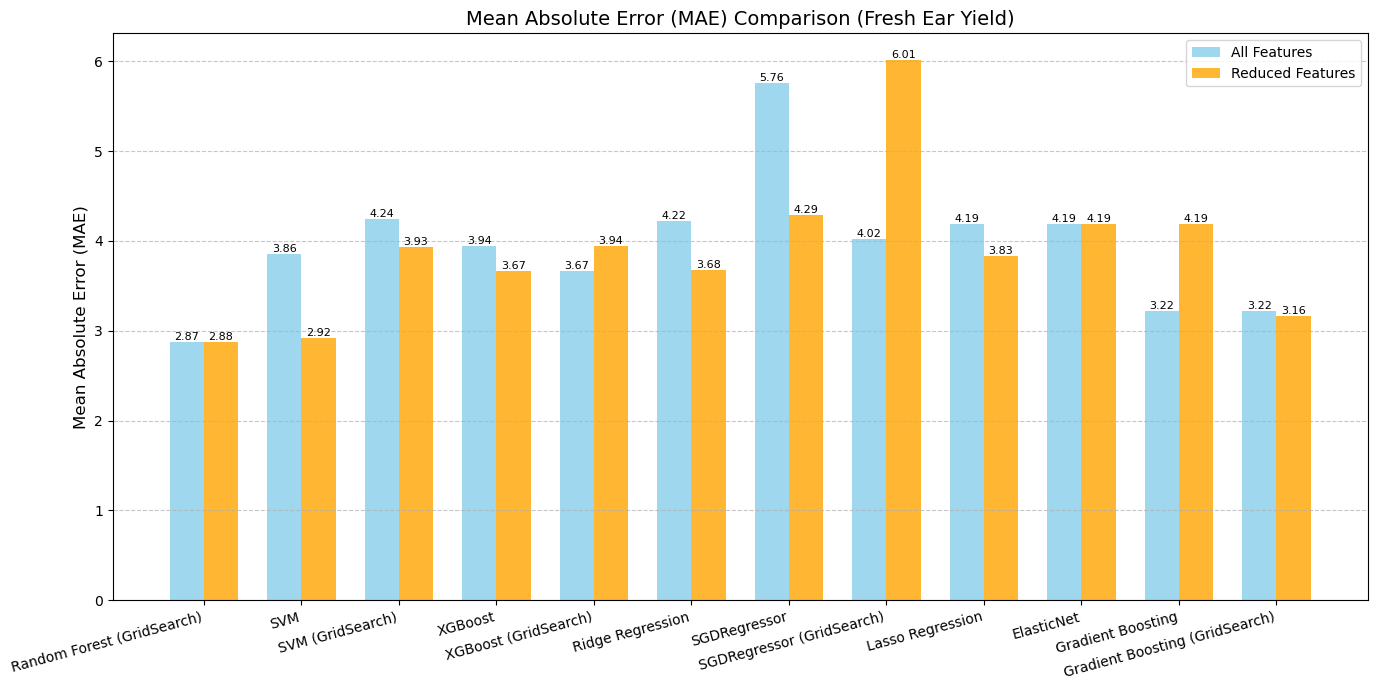

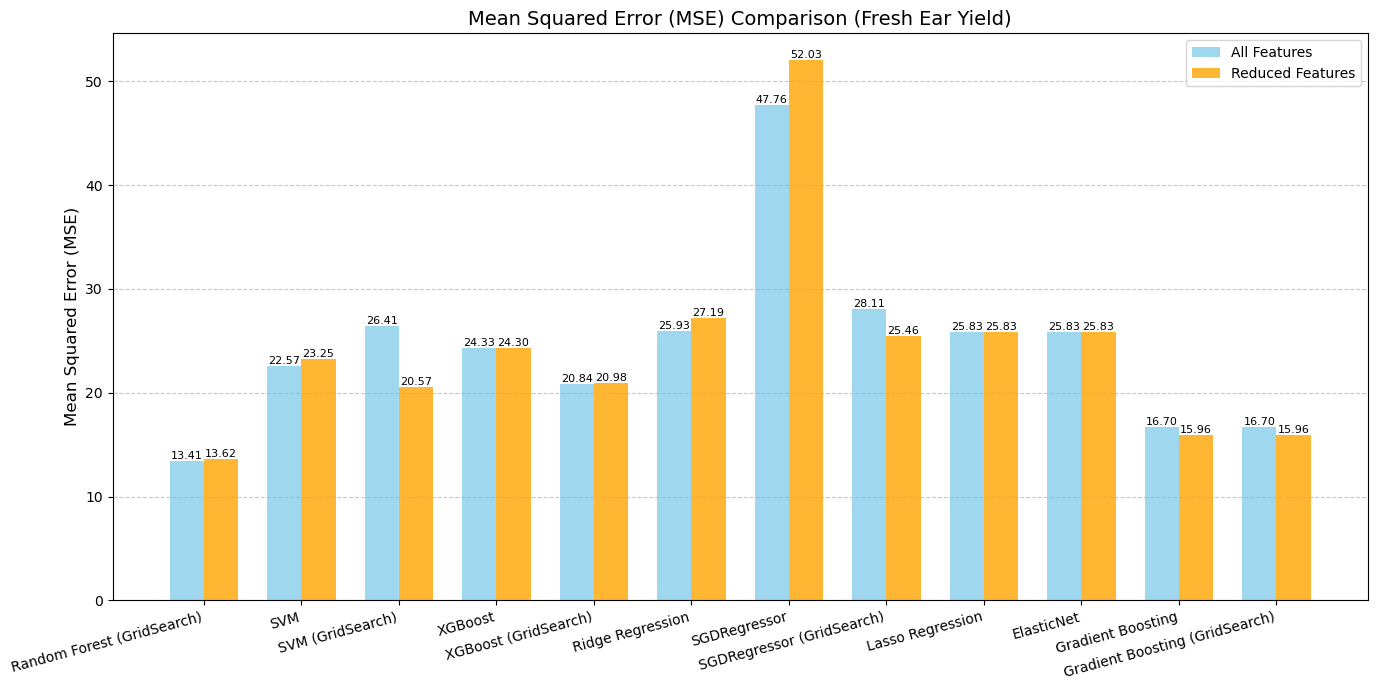

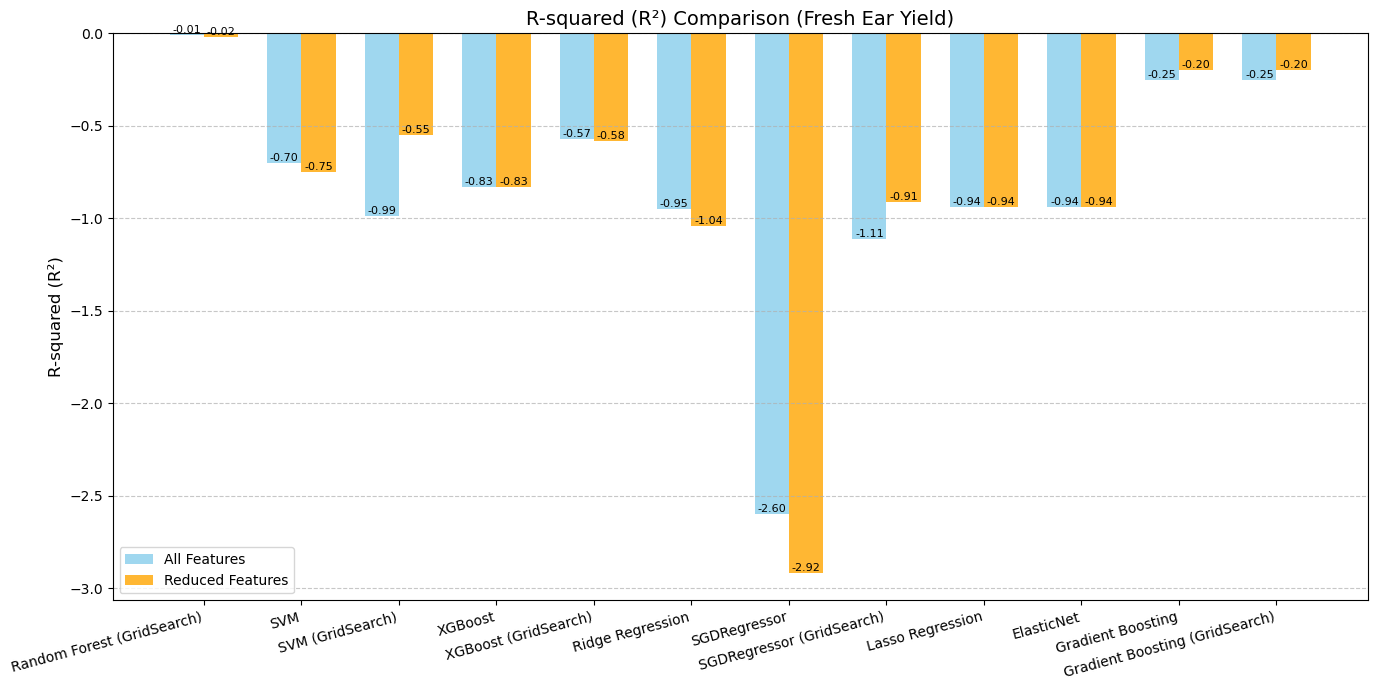

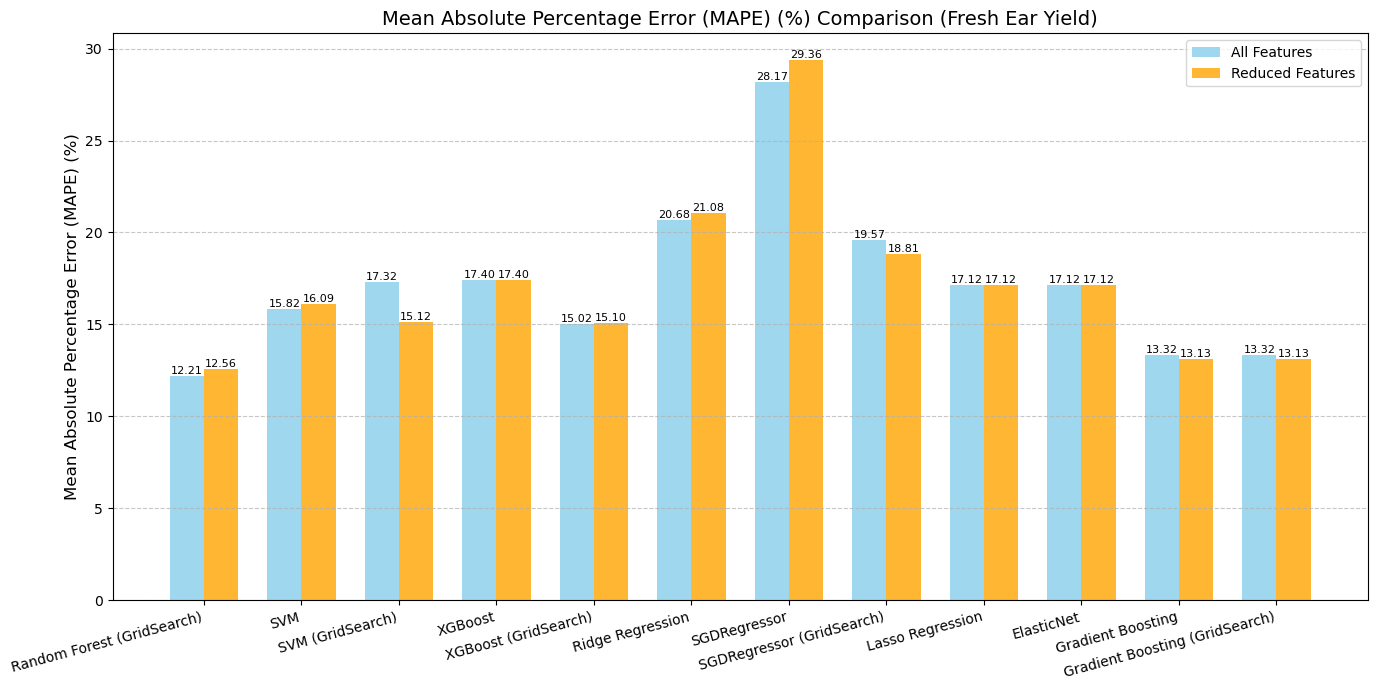

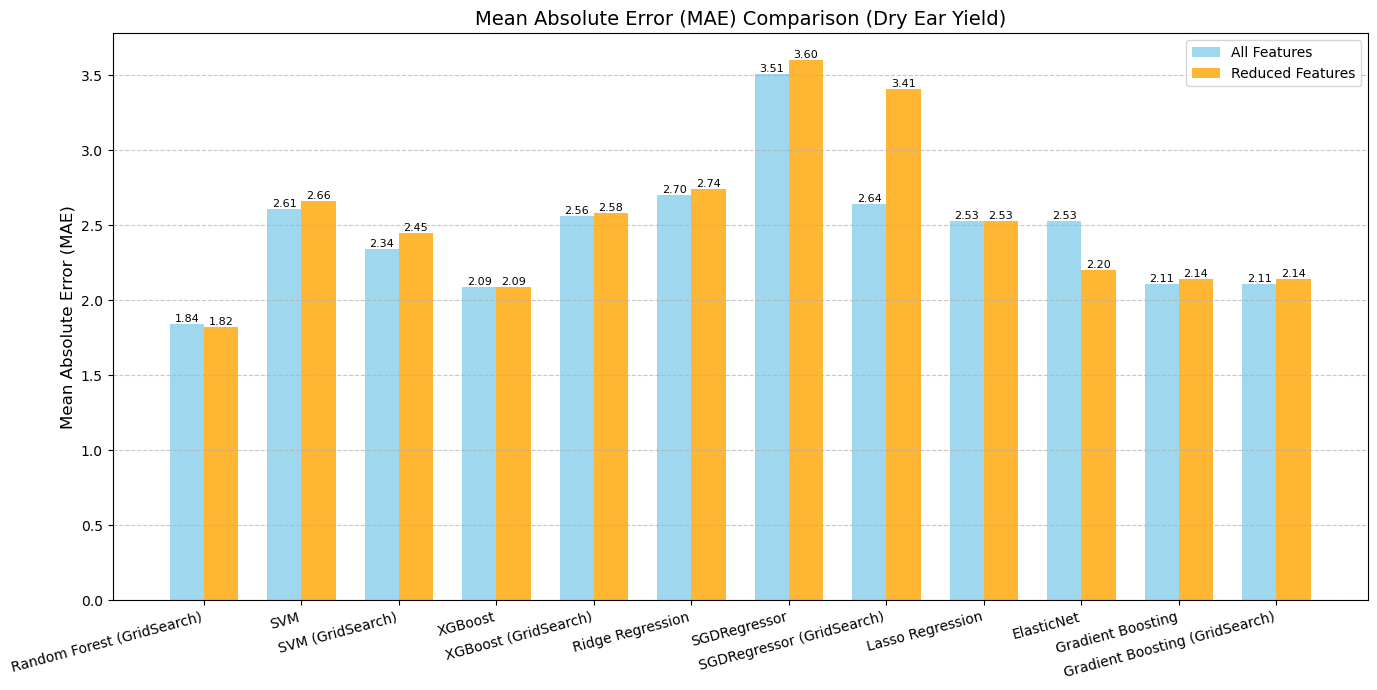

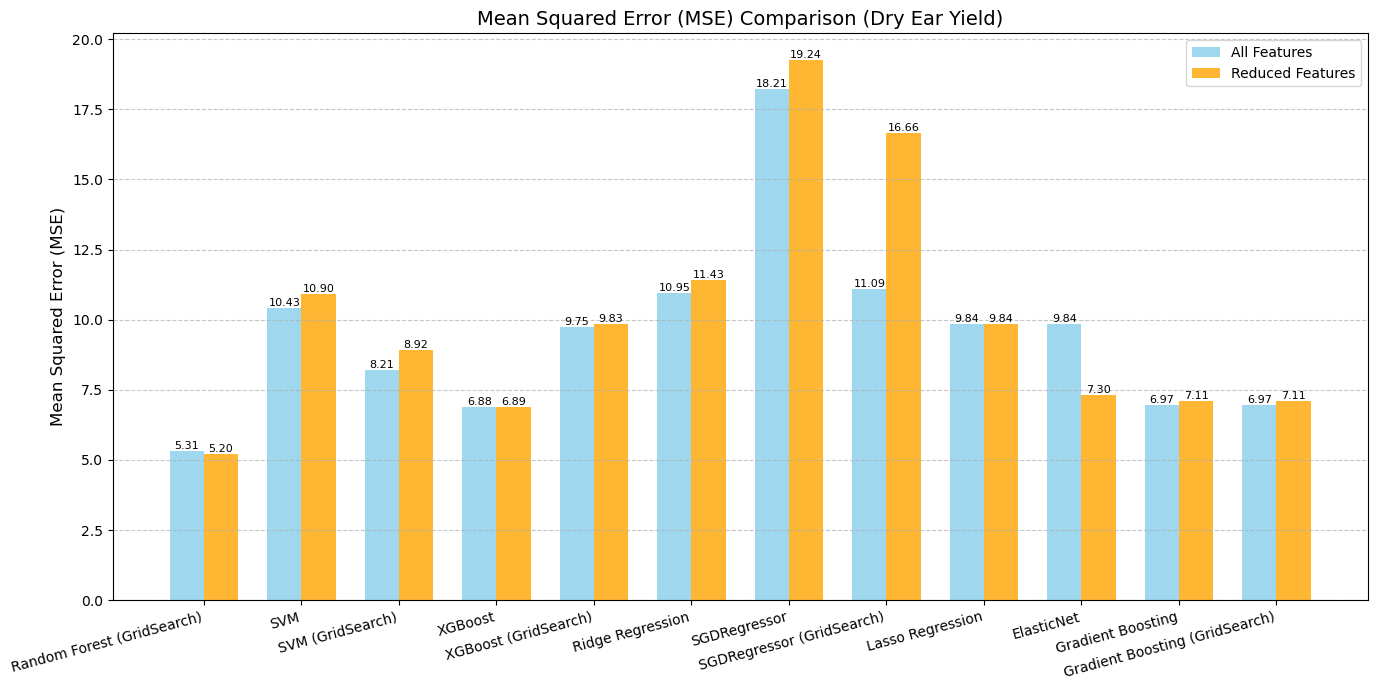

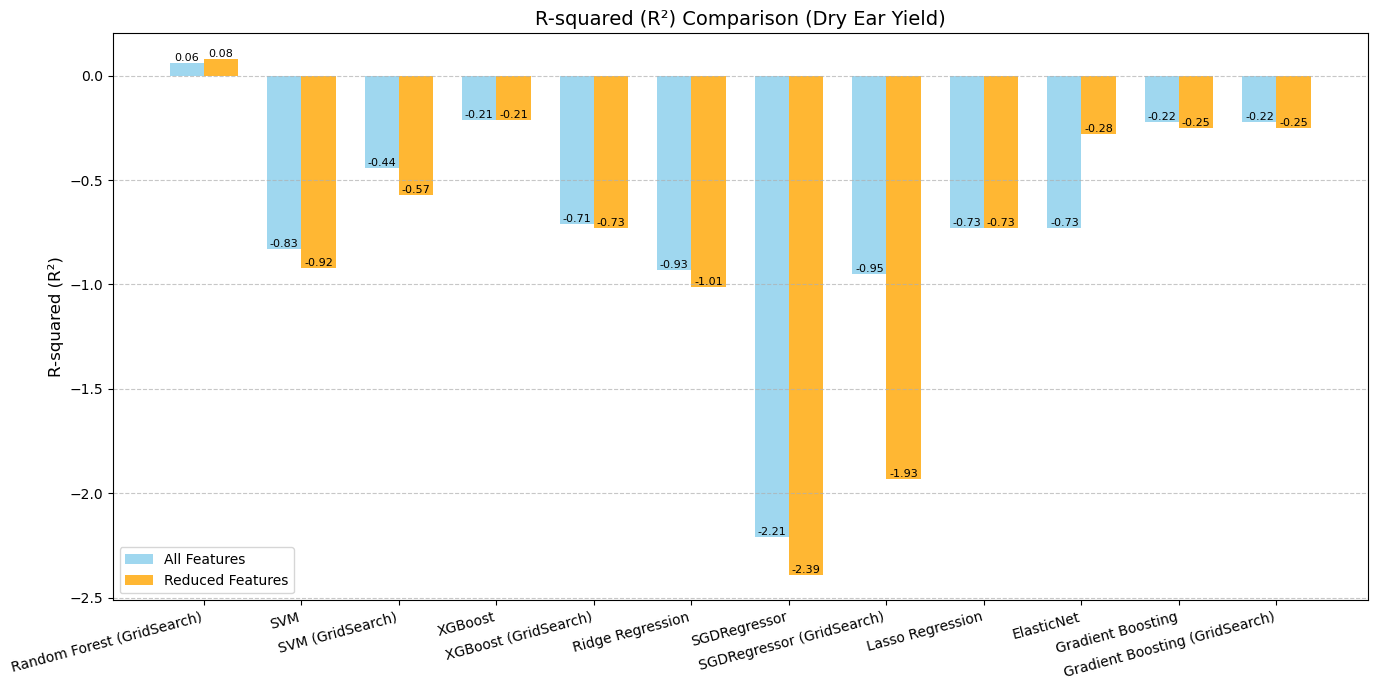

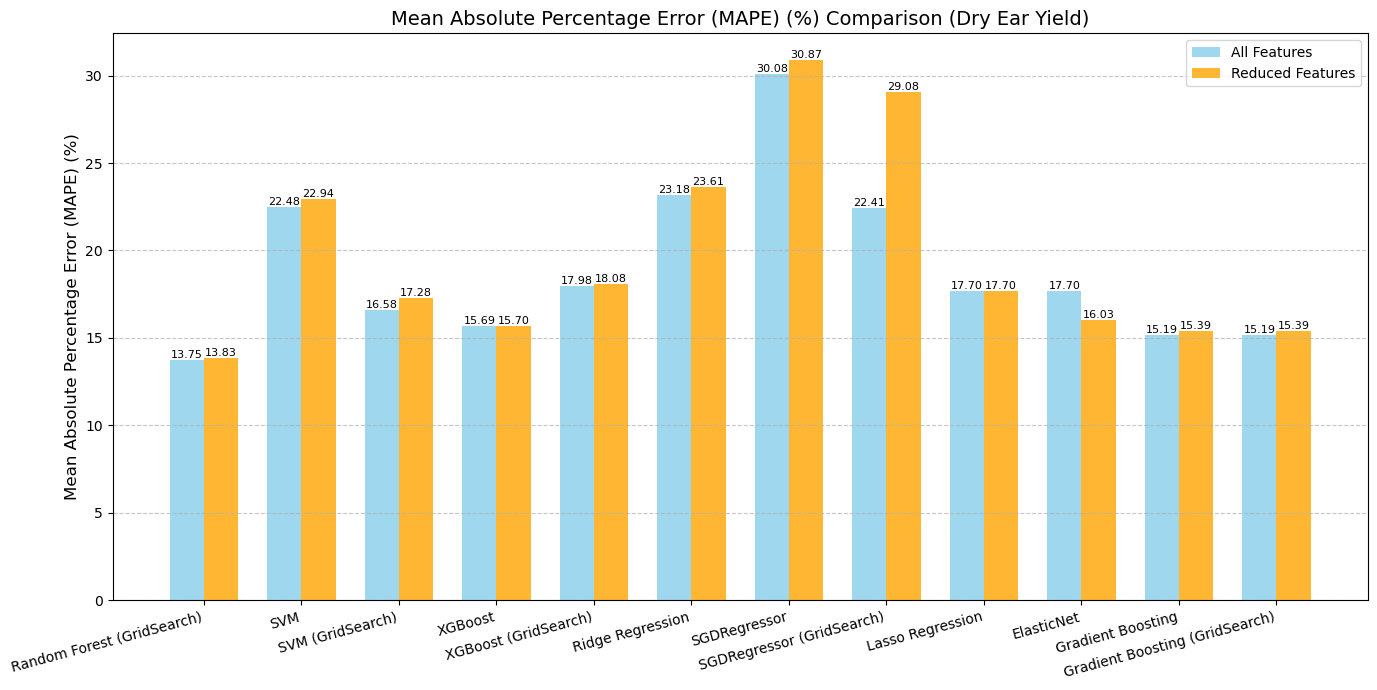

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Define model names
models = [
    "Random Forest (GridSearch)", 
    "SVM", 
    "SVM (GridSearch)", 
    "XGBoost", 
    "XGBoost (GridSearch)", 
    "Ridge Regression",
    "SGDRegressor",
    "SGDRegressor (GridSearch)",
    "Lasso Regression",
    "ElasticNet",
    "Gradient Boosting",
    "Gradient Boosting (GridSearch)"
]

# Define metrics for Fresh Ear Yield (All Features)
mae_fresh_all = [2.87, 3.86, 4.24, 3.94, 3.67, 4.22, 5.76, 4.02, 4.19, 4.19, 3.22, 3.22]
mse_fresh_all = [13.41, 22.57, 26.41, 24.33, 20.84, 25.93, 47.76, 28.11, 25.83, 25.83, 16.70, 16.70]
r2_fresh_all = [-0.01, -0.70, -0.99, -0.83, -0.57, -0.95, -2.60, -1.11, -0.94, -0.94, -0.25, -0.25]
mape_fresh_all = [12.21, 15.82, 17.32, 17.40, 15.02, 20.68, 28.17, 19.57, 17.12, 17.12, 13.32, 13.32]

# Define metrics for Fresh Ear Yield (Reduced Features)
mae_fresh_reduced = [2.88, 2.92, 3.93, 3.67, 3.94, 3.68, 4.29, 6.01, 3.83, 4.19, 4.19, 3.16]
mse_fresh_reduced = [13.62, 23.25, 20.57, 24.30, 20.98, 27.19, 52.03, 25.46, 25.83, 25.83, 15.96, 15.96]
r2_fresh_reduced = [-0.02, -0.75, -0.55, -0.83, -0.58, -1.04, -2.92, -0.91, -0.94, -0.94, -0.20, -0.20]
mape_fresh_reduced = [12.56, 16.09, 15.12, 17.40, 15.10, 21.08, 29.36, 18.81, 17.12, 17.12, 13.13, 13.13]

# Define metrics for Dry Ear Yield (All Features)
mae_dry_all = [1.84, 2.61, 2.34, 2.09, 2.56, 2.70, 3.51, 2.64, 2.53, 2.53, 2.11, 2.11]
mse_dry_all = [5.31, 10.43, 8.21, 6.88, 9.75, 10.95, 18.21, 11.09, 9.84, 9.84, 6.97, 6.97]
r2_dry_all = [0.06, -0.83, -0.44, -0.21, -0.71, -0.93, -2.21, -0.95, -0.73, -0.73, -0.22, -0.22]
mape_dry_all = [13.75, 22.48, 16.58, 15.69, 17.98, 23.18, 30.08, 22.41, 17.70, 17.70, 15.19, 15.19]

# Define metrics for Dry Ear Yield (Reduced Features)
mae_dry_reduced = [1.82, 2.66, 2.45, 2.09, 2.58, 2.74, 3.60, 3.41, 2.53, 2.20, 2.14, 2.14]
mse_dry_reduced = [5.20, 10.90, 8.92, 6.89, 9.83, 11.43, 19.24, 16.66, 9.84, 7.30, 7.11, 7.11]
r2_dry_reduced = [0.08, -0.92, -0.57, -0.21, -0.73, -1.01, -2.39, -1.93, -0.73, -0.28, -0.25, -0.25]
mape_dry_reduced = [13.83, 22.94, 17.28, 15.70, 18.08, 23.61, 30.87, 29.08, 17.70, 16.03, 15.39, 15.39]

# Plot comparison
def plot_metric(metric_all, metric_reduced, metric_name, target_name):
    x = np.arange(len(models))  # Number of models
    width = 0.35  # Bar width
    plt.figure(figsize=(14, 7))
    bars_all = plt.bar(x - width/2, metric_all, width, label="All Features", color='skyblue', alpha=0.8)
    bars_reduced = plt.bar(x + width/2, metric_reduced, width, label="Reduced Features", color='orange', alpha=0.8)

    # Add data labels
    for bar in bars_all:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=8)
    for bar in bars_reduced:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=8)

    plt.xticks(x, models, rotation=15, ha='right', fontsize=10)
    plt.ylabel(metric_name, fontsize=12)
    plt.title(f"{metric_name} Comparison ({target_name})", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize metrics for Fresh Ear Yield
plot_metric(mae_fresh_all, mae_fresh_reduced, "Mean Absolute Error (MAE)", "Fresh Ear Yield")
plot_metric(mse_fresh_all, mse_fresh_reduced, "Mean Squared Error (MSE)", "Fresh Ear Yield")
plot_metric(r2_fresh_all, r2_fresh_reduced, "R-squared (R²)", "Fresh Ear Yield")
plot_metric(mape_fresh_all, mape_fresh_reduced, "Mean Absolute Percentage Error (MAPE) (%)", "Fresh Ear Yield")

# Visualize metrics for Dry Ear Yield
plot_metric(mae_dry_all, mae_dry_reduced, "Mean Absolute Error (MAE)", "Dry Ear Yield")
plot_metric(mse_dry_all, mse_dry_reduced, "Mean Squared Error (MSE)", "Dry Ear Yield")
plot_metric(r2_dry_all, r2_dry_reduced, "R-squared (R²)", "Dry Ear Yield")
plot_metric(mape_dry_all, mape_dry_reduced, "Mean Absolute Percentage Error (MAPE) (%)", "Dry Ear Yield")


# Visualization Result for Random Forest 

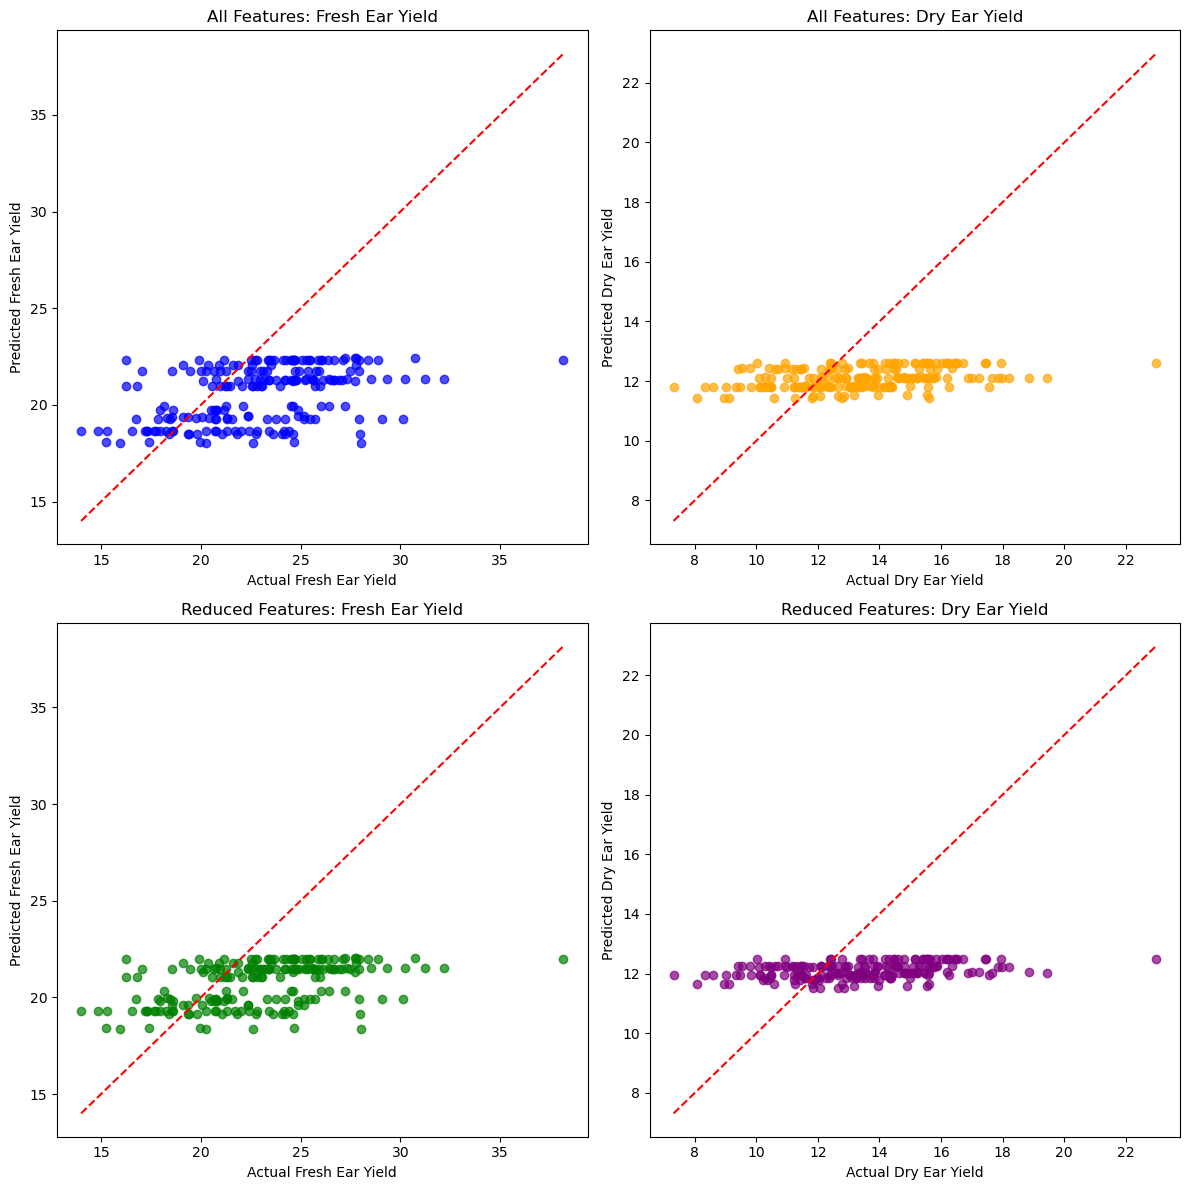

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots in one figure
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# --------------------------------------------------------
# 1) ALL FEATURES - FRESH EAR YIELD (axes[0, 0])
# --------------------------------------------------------
axes[0, 0].scatter(
    y_test_all['fresh_ear_yield'], 
    y_pred_fresh_all, 
    alpha=0.7, 
    color='blue'
)
axes[0, 0].set_xlabel('Actual Fresh Ear Yield')
axes[0, 0].set_ylabel('Predicted Fresh Ear Yield')
axes[0, 0].set_title('All Features: Fresh Ear Yield')

# Reference line y = x
min_val = min(y_test_all['fresh_ear_yield'].min(), y_pred_fresh_all.min())
max_val = max(y_test_all['fresh_ear_yield'].max(), y_pred_fresh_all.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--')

# --------------------------------------------------------
# 2) ALL FEATURES - DRY EAR YIELD (axes[0, 1])
# --------------------------------------------------------
axes[0, 1].scatter(
    y_test_all['dry_ear_yield'], 
    y_pred_dry_all, 
    alpha=0.7, 
    color='orange'
)
axes[0, 1].set_xlabel('Actual Dry Ear Yield')
axes[0, 1].set_ylabel('Predicted Dry Ear Yield')
axes[0, 1].set_title('All Features: Dry Ear Yield')

# Reference line y = x
min_val = min(y_test_all['dry_ear_yield'].min(), y_pred_dry_all.min())
max_val = max(y_test_all['dry_ear_yield'].max(), y_pred_dry_all.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--')

# --------------------------------------------------------
# 3) REDUCED FEATURES - FRESH EAR YIELD (axes[1, 0])
# --------------------------------------------------------
axes[1, 0].scatter(
    y_test_reduced['fresh_ear_yield'], 
    y_pred_fresh_reduced, 
    alpha=0.7, 
    color='green'
)
axes[1, 0].set_xlabel('Actual Fresh Ear Yield')
axes[1, 0].set_ylabel('Predicted Fresh Ear Yield')
axes[1, 0].set_title('Reduced Features: Fresh Ear Yield')

# Reference line y = x
min_val = min(y_test_reduced['fresh_ear_yield'].min(), y_pred_fresh_reduced.min())
max_val = max(y_test_reduced['fresh_ear_yield'].max(), y_pred_fresh_reduced.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--')

# --------------------------------------------------------
# 4) REDUCED FEATURES - DRY EAR YIELD (axes[1, 1])
# --------------------------------------------------------
axes[1, 1].scatter(
    y_test_reduced['dry_ear_yield'], 
    y_pred_dry_reduced, 
    alpha=0.7, 
    color='purple'
)
axes[1, 1].set_xlabel('Actual Dry Ear Yield')
axes[1, 1].set_ylabel('Predicted Dry Ear Yield')
axes[1, 1].set_title('Reduced Features: Dry Ear Yield')

# Reference line y = x
min_val = min(y_test_reduced['dry_ear_yield'].min(), y_pred_dry_reduced.min())
max_val = max(y_test_reduced['dry_ear_yield'].max(), y_pred_dry_reduced.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--')

# Adjust layout so labels/titles don’t overlap
plt.tight_layout()
plt.show()


# Visualization Result for Random Forest with Grid-Search

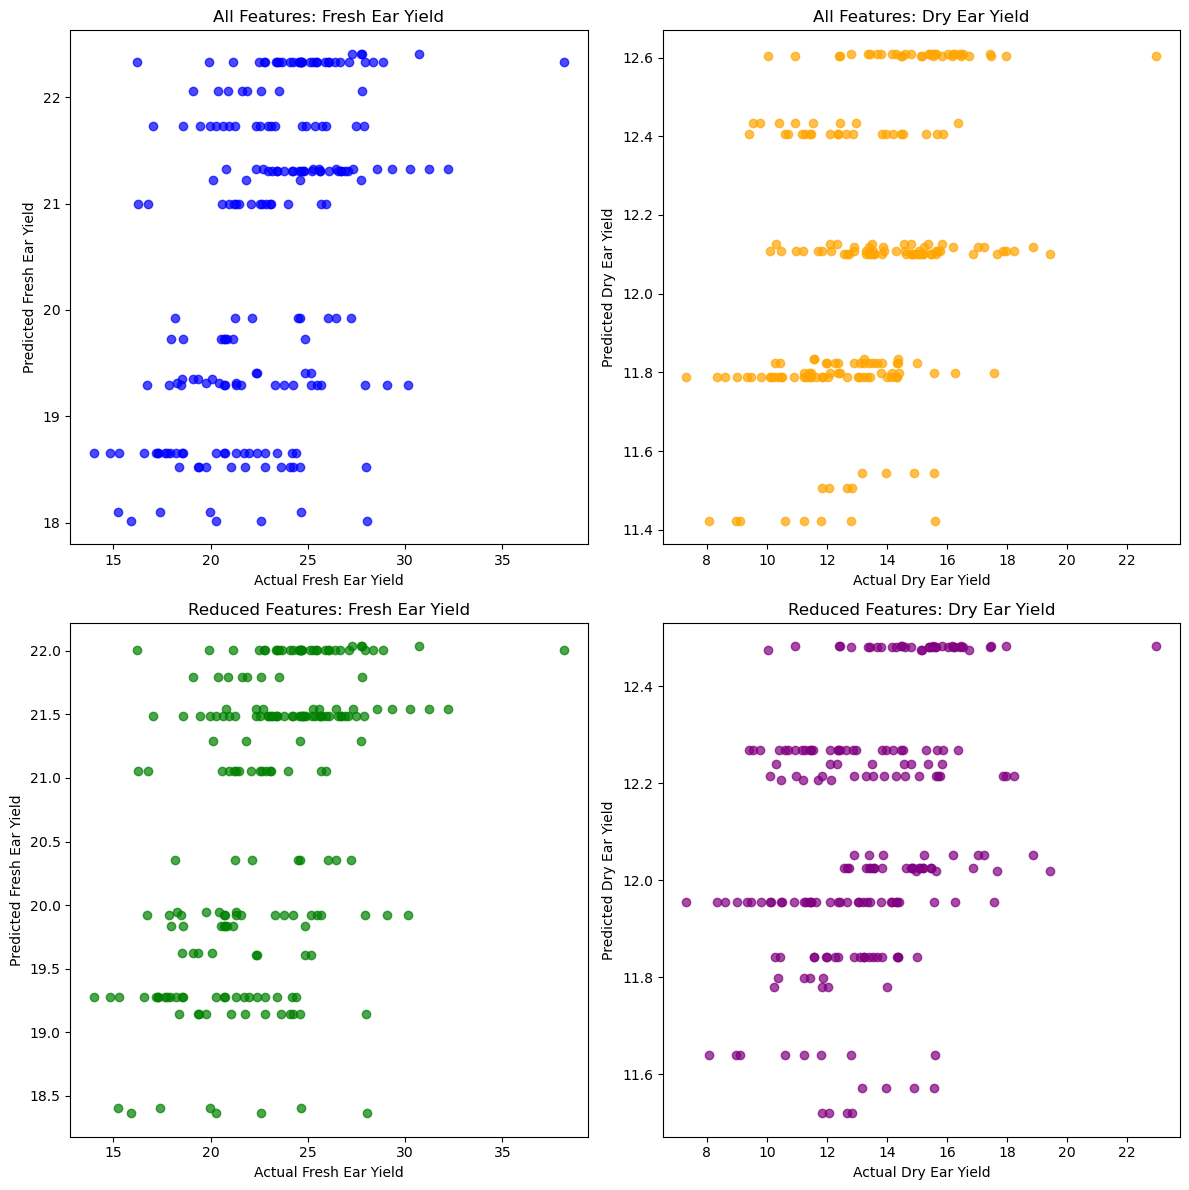

In [55]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots in one figure
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# -------------------------------------------------------
# 1) ALL FEATURES - FRESH EAR YIELD (axes[0, 0])
# -------------------------------------------------------
axes[0, 0].scatter(
    y_test_all['fresh_ear_yield'],
    y_pred_fresh_all,
    alpha=0.7,
    color='blue'
)
axes[0, 0].set_xlabel('Actual Fresh Ear Yield')
axes[0, 0].set_ylabel('Predicted Fresh Ear Yield')
axes[0, 0].set_title('All Features: Fresh Ear Yield')

# Add a reference line y = x
min_val = min(y_test_all['fresh_ear_yield'].min(), y_pred_fresh_all.min())
max_val = max(y_test_all['fresh_ear_yield'].max(), y_pred_fresh_all.max())

# -------------------------------------------------------
# 2) ALL FEATURES - DRY EAR YIELD (axes[0, 1])
# -------------------------------------------------------
axes[0, 1].scatter(
    y_test_all['dry_ear_yield'],
    y_pred_dry_all,
    alpha=0.7,
    color='orange'
)
axes[0, 1].set_xlabel('Actual Dry Ear Yield')
axes[0, 1].set_ylabel('Predicted Dry Ear Yield')
axes[0, 1].set_title('All Features: Dry Ear Yield')

# Add a reference line y = x
min_val = min(y_test_all['dry_ear_yield'].min(), y_pred_dry_all.min())
max_val = max(y_test_all['dry_ear_yield'].max(), y_pred_dry_all.max())

# -------------------------------------------------------
# 3) REDUCED FEATURES - FRESH EAR YIELD (axes[1, 0])
# -------------------------------------------------------
axes[1, 0].scatter(
    y_test_reduced['fresh_ear_yield'],
    y_pred_fresh_reduced,
    alpha=0.7,
    color='green'
)
axes[1, 0].set_xlabel('Actual Fresh Ear Yield')
axes[1, 0].set_ylabel('Predicted Fresh Ear Yield')
axes[1, 0].set_title('Reduced Features: Fresh Ear Yield')

# Add a reference line y = x
min_val = min(y_test_reduced['fresh_ear_yield'].min(), y_pred_fresh_reduced.min())
max_val = max(y_test_reduced['fresh_ear_yield'].max(), y_pred_fresh_reduced.max())


# -------------------------------------------------------
# 4) REDUCED FEATURES - DRY EAR YIELD (axes[1, 1])
# -------------------------------------------------------
axes[1, 1].scatter(
    y_test_reduced['dry_ear_yield'],
    y_pred_dry_reduced,
    alpha=0.7,
    color='purple'
)
axes[1, 1].set_xlabel('Actual Dry Ear Yield')
axes[1, 1].set_ylabel('Predicted Dry Ear Yield')
axes[1, 1].set_title('Reduced Features: Dry Ear Yield')

# Add a reference line y = x
min_val = min(y_test_reduced['dry_ear_yield'].min(), y_pred_dry_reduced.min())
max_val = max(y_test_reduced['dry_ear_yield'].max(), y_pred_dry_reduced.max())


# Make sure labels and titles don’t overlap
plt.tight_layout()
plt.show()


# Save Model 

In [46]:
import joblib

# --------------------------------------------------------
# save Model for Random Forest 
# --------------------------------------------------------
joblib.dump(rf_model_fresh_all, "rf_model_fresh_all.pkl")
joblib.dump(rf_model_dry_all, "rf_model_dry_all.pkl")

joblib.dump(rf_model_fresh_reduced, "rf_model_fresh_reduced.pkl")
joblib.dump(rf_model_dry_reduced, "rf_model_dry_reduced.pkl")


# --------------------------------------------------------
# save Model for Random Forest with Grid-Search
# --------------------------------------------------------
# Save best estimator for All Features - Fresh Ear Yield
joblib.dump(best_rf_fresh_all, "best_rf_fresh_all.pkl")

# Save best estimator for All Features - Dry Ear Yield
joblib.dump(best_rf_dry_all, "best_rf_dry_all.pkl")

# Save best estimator for Reduced Features - Fresh Ear Yield
joblib.dump(best_rf_fresh_reduced, "best_rf_fresh_reduced.pkl")

# Save best estimator for Reduced Features - Dry Ear Yield
joblib.dump(best_rf_dry_reduced, "best_rf_dry_reduced.pkl")


['best_rf_dry_reduced.pkl']